# A Deep Learning Approach to Limit Order Book Forecasting
By Aric Cutuli<br>
***

## Opening Remarks
The enigma concerning the predictability of markets has always been the principal driver of my interest in finance, and it inpires my ongoing exploration of machine learning's applications within the analysis and forecasting of financial time series. Today, we compare the performance of a studied deep learning model for limit order book forecasting on two stationary representations of the limit order book.

## Abstract
In this notebook, we implement an artificial neural network originally employed by Zhang et al[<sub>[1]</sub>](#ref1) that combines convolutional neural networks (CNNs) and a long short-term memory (LSTM) neural network in order to classify future directions of an order book at a high frequency. Specifically, given Coinbase order book data for Bitcoin, we seek to predict whether the mid price increases, decreases, or does not change in the next observation of the time series. Unlike Zhang et al's papers we reference[<sub>[1]</sub>](#ref1)[<sub>[2]</sub>](#ref2), which use non-stationary order book states as inputs to the network, our instantiation of the architecture is trained on order flow and order flow imbalance, which are stationary quantities derived from the limit order book[<sub>[3]</sub>](#ref3). Hence, this discussion also draws heavy inspiration from a 2021 article by Kolm et al[<sub>[4]</sub>](#ref4), which demonstrated that forecasting using order flow significantly outperforms raw order book inputs. Today, we further this discussion by doing an analysis of the impact that differencing order flow into order flow imbalance has on the forecasting performance of the model. We also approach the problem from a time series modeling perspective via the Box-Jenkins method, a procedure that was not explicitly documented in those papers.

## Order Books, Flow, and Imbalance
Today's trading of equities and other securities is often facilitated by a [*limit order book*](https://en.wikipedia.org/wiki/Order_book), also known as an *order book*. The order book collects bids and offers made by prospective buyers and sellers and determines which incoming orders get executed and which are added to the book. The *bid price* is the highest price buyers are prepared to buy at, and the *ask price* is the lowest price sellers are willing to sell at. The *mid price*, which our model seeks to predict moves in, is the midpoint of the bid price and the ask price.

An order is defined by its side, quantity demanded, price to trade at, and time of submission. As one enters the system, the matching engine of the exchange tries to match the order with existing orders in the book. Orders that match are executed and called *market orders*, and orders that do not match or only partially match are added to the book and called *limit orders*.

[<img src='Images/Limit-order-book-diagram-A-new-buy-limit-order-arrives-at-price-bt-increasing-the.png' style='width:425px;height:312px'/>](https://www.researchgate.net/figure/Limit-order-book-diagram-A-new-buy-limit-order-arrives-at-price-bt-increasing-the_fig1_297725489)

Our model takes as inputs representations of the first ten levels of the order book. A level is denoted by its price and volume that is bid or asked. So, as we progress down levels on the bid side of the order book, the price decreases, and as we progress down levels of the ask side, the price increases. Each observation in our dataset will be a 40-variable vector displaying the price and volume for each of the top ten bid and ask levels, giving us a truncated screenshot of the *state of the limit order book* at each timestep. 

$$ \text{s}_t^{LOB} := (a_t^1, v_t^{1,a}, b_t^1, v_t^{1,b}, ..., a_t^{10}, v_t^{10,a}, b_t^{10}, v_t^{10,b})^T \in \mathbb{R}^{40} $$

We define the *bid order flows* (bOF) and *ask order flows* (aOF) at a timestamp to be 10-variable vectors computed using two consecutive order book states, where each element is given by

$$ \text{bOF}_{t,i} :=   \left\{
\begin{array}{ll}
      v_t^{i,b}, & b_t^i > b_{t-1}^i \\
      v_t^{i,b} - v_{t-1}^{i,b}, & b_t^i = b_{t-1}^i \\
      -v_t^{i,b}, & b_t^i < b_{t-1}^i \\
\end{array} 
\right. $$

$$ \text{aOF}_{t,i} :=   \left\{
\begin{array}{ll}
      -v_t^{i,a}, & a_t^i > a_{t-1}^i \\
      v_t^{i,a} - v_{t-1}^{i,a}, & a_t^i = a_{t-1}^i \\
      v_t^{i,a}, & a_t^i < a_{t-1}^i \\
\end{array} 
\right. $$

for $i = 1, ..., 10$. With this, we define *order flow* (OF)

$$ \text{OF}_t :=  (\text{bOF}_{t,1}, \text{aOF}_{t,1}, ..., \text{bOF}_{t,10}, \text{aOF}_{t,10})^T \in \mathbb{R}^{20} $$

and *order flow imbalance* (OFI)

$$ \text{OFI}_t := \text{bOF}_t - \text{aOF}_t \in \mathbb{R}^{10}. $$

While a sequence of limit order book states is a complex non-stationary process, the above formulas for order flow and order flow imbalance transform consecutive order book states into a [stationary process](https://en.wikipedia.org/wiki/Stationary_process). This property allows for our eventual test test of the deep learning model to be reasonably similar to the training set and thus appropriate to predict off of using the model. It also allows for more ease in the learning of long-term dependencies by our LSTM layer, which Kolm et al see as a reason behind their finding that sequence length only marginally impacted model performance[<sub>[4]</sub>](#ref4). On a separate note, when trained on order flow, which keeps the bid and ask sides separate, the CNN layers of our model will be given the added flexibility of being able to combine bid and ask order flows asymmetrically, so we hypothesize that our forecasting model will perform better on order flow than on order flow imbalance. This theory is expressed by Kolm et al[<sub>[4]</sub>](#ref4) and shared by time series analysis theory[<sub>[5]</sub>](#ref5).

## Introducing the CNN-LSTM Model
While the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that a feedforward neural network with a single hidden layer can approximate any continuous function on any compact set, different neural network architectures are capable of exploiting unique structures in data, a quality that is particularly useful for the learning of complex financial time series. These different architectures, which include CNNs and LSTMs among others, can compress data and change their behavior over time in a way that supports their efficacy in difficult modeling situations. On the other hand, simple feedforward neural networks can suffer from instability and less interpretability when seeking to learn complex relationships in data[<sub>[6]</sub>](#ref6).

Although artificial neural networks can be used individually, they are often complementary in their modeling capabilities and, when used together, can learn unique structures in data and improve a model's ability to execute a desired task. For instance, our CNN-LSTM model architecture we adopt consists of CNN layers and an Inception Module that compress and wrap the order book data in a manner that allows a LSTM module to learn temporal dependencies from a smaller parameter space, leading to a more parsimonious model[<sub>[1]</sub>](#ref1).

[*Convolutional neural networks*](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) are feedforward neural networks that can exploit data locality in an input, so in the CNN-LSTM model, CNN layers reduce the dimension of the multivariate input by aggregating bid and ask sides and levels in the order book. The output of these convolutional layers serve as an input to the [*Inception Module*](https://arxiv.org/pdf/1409.4842v1.pdf), which wraps convolutions together to capture behavior over multiple timescales, acting as a sort of moving average indicator whose decay weights are learned via [backpropagation](https://en.wikipedia.org/wiki/Backpropagation)[<sub>[1]</sub>](#ref1). Then, the outputs of the Inception Module are concatenated and reshaped into an input to the [*long short-term memory*](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) layer. LSTMs are a class of [*recurrent neural networks*](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs) that are designed to handle temporal dependencies in sequential data and alleviate the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) faced by generic RNNs[<sub>[7]</sub>](#ref7). The LSTM unit consists of a memory cell and three gates that determine what information should be remembered by the memory cell. For an $ n $-dimensional input vector $\text{x}_t$, the LSTM unit is defined by

$$ \text{f}_t = \sigma (\text{U}^f \text{x}_t + \text{W}^f \text{h}_{t-1} + \text{b}^f) $$
$$ \text{i}_t = \sigma (\text{U}^i \text{x}_t + \text{W}^i \text{h}_{t-1} + \text{b}^i) $$
$$ \text{o}_t = \sigma (\text{U}^o \text{x}_t + \text{W}^o \text{h}_{t-1} + \text{b}^o) $$
$$ \text{c}_t = \text{f}_t \circ \text{c}_{t-1} + \text{i}_t \circ \text{tanh} (\text{U}^c \text{x}_t + \text{W}^c \text{h}_{t-1} + \text{b}^c) $$
$$ \text{h}_t = \text{o}_t \circ \text{tanh} (\text{c}_t) $$

where $ m $ is the number of LSTM units in the module, $ \sigma := (1+e^{-x})^{-1} $ is the sigmoid activation function, $ \text{f}_t \in \mathbb{R}^m $ is the forget gate's activation vector, $ \text{i}_t \in \mathbb{R}^m $ is the input gate's activation vector, $ \text{o}_t \in \mathbb{R}^m $ is the output gate's activation vector, $ \text{c}_t \in \mathbb{R}^m $ is the LSTM unit's hidden state vector, and $ \text{h}_t \in \mathbb{R}^m $ is the unit's output vector. $ \text{U} \in \mathbb{R}^{m \times n} $, $ \text{W} \in \mathbb{R}^{m \times m} $, and $ \text{b} \in \mathbb{R}^m $ are learned during training and represent the weight matrices in connection to the input vector, the weight matrices in connection to the previous output state, and the bias vectors, respectively. 

[<img src='Images/lstm.png' style='width:500px;height:390px'/>](https://blog.mlreview.com/understanding-lstm-and-its-diagrams-37e2f46f1714)

Moreover, Zhang et al[<sub>[2]</sub>](#ref2) showcase the performance benefit of applying [variational dropout](https://arxiv.org/pdf/1512.05287v5.pdf) to the model by serving as a stochastic [regularizer](https://en.wikipedia.org/wiki/Regularization_(mathematics)) to reduce [overfitting](https://en.wikipedia.org/wiki/Overfitting) and make decisions with some understanding of the predictive variation produced by our model parameters. That is, with [*Monte-Carlo (MC) dropout*](https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/mc-dropout.html), we can add [epistemic uncertainty](https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic)[<sup>1</sup>](#fn1) to our neural network architecture by making multiple predictions and dropping a different random sample of neurons with every forward pass. This random sampling leads to different predictions on each evaluation iteration, so we can average the results to—in theory—improve out-of-sample predictions. The dropout layer is inserted after the Inception Module, and we determine its rate with [cross-validated grid-search](https://scikit-learn.org/stable/modules/grid_search.html).

Lastly, since we formulate this forecasting problem as one of classification, we add an output layer with a [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function), resulting in a final output whose elements represent the probability of observing each price movement in the next timestamp. We train the models by minimizing [categorical cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) with [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) using the [Adam optimization algorithm](https://arxiv.org/pdf/1412.6980.pdf), whose parameters we set to those of the DeepLOB implementation of the model[<sub>[1]</sub>](#ref1).

<sup>1. </sup><span id="fn1"><sup>Here, epistemic uncertainty refers to the fact that we don't have an analytical understanding of the posterior distribution of the model parameters. Because of our lack of data, we are uncertain of the integrity of the model parameters we estimate via backpropagation.</sup></span>

In [227]:
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def CNN_LSTM(time_series, lag_param, dropout):
    
    # Convolutions across LOB levels
    if time_series == 'OF':
        input_tensor = Input(shape=(lag_param,20,1))
        # Combine imbalance information across sides for each level of the order book
        layer_x = layers.Conv2D(filters=16, kernel_size=(1,2), strides=(1,2))(input_tensor)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
        # Combine imbalance information across time for each side and level of the order book
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(layer_x)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(layer_x)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    elif time_series == 'OFI':
        input_tensor = Input(shape=(lag_param,10,1))
        # Combine imbalance information across time for each side and level of the order book
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(input_tensor)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(layer_x)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    else:
        raise Exception("'time_series' should be 'OF' or 'OFI'")

    # Combine imbalance information across all levels of the book
    layer_x = layers.Conv2D(filters=16, kernel_size=(1,10))(layer_x)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)

    # Inception Module
    # Tower 1
    tower_1 = layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(layer_x)
    tower_1 = layers.LeakyReLU(alpha=0.01)(tower_1)
    tower_1 = layers.Conv2D(filters=32, kernel_size=(3,1), padding='same')(tower_1)
    tower_1 = layers.LeakyReLU(alpha=0.01)(tower_1)
    # Tower 2
    tower_2 = layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(layer_x)
    tower_2 = layers.LeakyReLU(alpha=0.01)(tower_2)
    tower_2 = layers.Conv2D(filters=32, kernel_size=(5,1), padding='same')(tower_2)
    tower_2 = layers.LeakyReLU(alpha=0.01)(tower_2)  
    # Tower 3
    tower_3 = layers.MaxPooling2D(pool_size=(3,1), padding='same', strides=(1,1))(layer_x)
    tower_3 = layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(tower_3)
    tower_3 = layers.LeakyReLU(alpha=0.01)(tower_3)

    # Concatenation and reshaping
    layer_x = layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    layer_x = layers.Reshape(target_shape=(lag_param, 96))(layer_x)
    
    # Insert variational dropout layer
    # By setting training to true, we enable dropout during evaluation passes
    layer_x = layers.Dropout(dropout)(layer_x, training=True)
    
    # LSTM with 64 hidden units
    layer_x = layers.LSTM(units=64)(layer_x)
    
    # Final output layer
    output = layers.Dense(units=3, activation='softmax')(layer_x)
    
    model = Model(input_tensor, output)
    
    opt = Adam(learning_rate=0.01, epsilon=1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


In [228]:
model_details = {
    'OF': {
        'model': None, 'function': CNN_LSTM, 'data': None
    },
    'OFI': {
        'model': None, 'function': CNN_LSTM, 'data': None
    }
}

## Data
We scrape our data using [Coinbase's public API](https://github.com/danpaquin/coinbasepro-python). Our method pulls live order book state information for Bitcoin traded on Coinbase. We essentially have the ability to choose however many observations we desire. But to avoid processing the data pull for an obscene length of time, we unfortunately decide not to get as many observations as the datasets used in the aforementioned related papers, since the purpose of this notebook is not to submit a solution to the model risk management team but instead to showcase what I've taught myself in the past few months. That being said, we extract 100,000 observations over the course of about a day, and we add a couple extra to account for the transformations we make later.

In [226]:
import pandas as pd
import numpy as np
from cbpro import PublicClient
from time import time, strftime, gmtime

public_client = PublicClient()
lob_data = pd.DataFrame()
start = time()
while len(lob_data) < 100002:
    raw_data = pd.concat((pd.DataFrame.from_dict(public_client.get_product_order_book('BTC-USD',level=2)['asks'])[:10],
                     pd.DataFrame.from_dict(public_client.get_product_order_book('BTC-USD',level=2)['bids'])[:10]),axis=1)
    lob_data = pd.concat((lob_data, pd.concat((pd.DataFrame(raw_data.drop(2,axis=1).iloc[i]).T for i in range(10)), axis=1).apply(lambda x: pd.Series(x.dropna().values))))
end = time()

print((end-start)/len(lob_data))

lob_data.columns = ['PRICE_ASK_1','VOLUME_ASK_1','PRICE_BID_1','VOLUME_BID_1',
           'PRICE_ASK_2','VOLUME_ASK_2','PRICE_BID_2','VOLUME_BID_2',
           'PRICE_ASK_3','VOLUME_ASK_3','PRICE_BID_3','VOLUME_BID_3',
           'PRICE_ASK_4','VOLUME_ASK_4','PRICE_BID_4','VOLUME_BID_4',
           'PRICE_ASK_5','VOLUME_ASK_5','PRICE_BID_5','VOLUME_BID_5',
           'PRICE_ASK_6','VOLUME_ASK_6','PRICE_BID_6','VOLUME_BID_6',
           'PRICE_ASK_7','VOLUME_ASK_7','PRICE_BID_7','VOLUME_BID_7',
           'PRICE_ASK_8','VOLUME_ASK_8','PRICE_BID_8','VOLUME_BID_8',
           'PRICE_ASK_9','VOLUME_ASK_9','PRICE_BID_9','VOLUME_BID_9',
           'PRICE_ASK_10','VOLUME_ASK_10','PRICE_BID_10','VOLUME_BID_10']
lob_data.index = range(len(lob_data))
lob_data = lob_data.astype(float)

0.7618932478344387


While it can vary between any two events in the dataset, the time interval between two observations is on average 0.7619 seconds. So, in lieu of the granularity that Zhang et al and Ntakaris et al boast in their respective datasets[<sub>[1]</sub>](#ref1)[<sub>[3]</sub>](#ref3)[<sub>[8]</sub>](#ref9), we simply extract labels for relative changes in only the next event. Just as in those datasets, our labels describe the percentage change of the mid price between events. For percentage changes greater than 0.002, we use label 1, for percentages change between -0.002 and 0.002, we use label 0, and for percentage changes smaller than -0.002, we use label -1.

In [256]:
lob_data['LABEL_1'] = np.zeros(len(lob_data))
for i in range(len(lob_data)-1):
    if (lob_data.loc[i+1,'PRICE_ASK_0'] + lob_data.loc[i+1,'PRICE_ASK_0']) > 1.00002*(lob_data.loc[i,'PRICE_ASK_0'] + lob_data.loc[i,'PRICE_ASK_0']):
        lob_data['LABEL_1'][i] = 1
    elif (lob_data.loc[i+1,'PRICE_BID_0'] + lob_data.loc[i+1,'PRICE_BID_0']) < 0.99998*(lob_data.loc[i,'PRICE_BID_0'] + lob_data.loc[i,'PRICE_BID_0']):
        lob_data['LABEL_1'][i] = -1
lob_data = lob_data.head(len(lob_data)-1)

# Save the LOB data
lob_data.to_csv('BTC-USD-LOB-{}'.format(strftime('%d-%b-%Y', gmtime())), index=False)

# Load the saved data
# lob_data = pd.read_csv('BTC-USD-LOB- ...')

lob_data

,PRICE_ASK_0,VOLUME_ASK_0,PRICE_BID_0,VOLUME_BID_0,PRICE_ASK_1,VOLUME_ASK_1,PRICE_BID_1,VOLUME_BID_1,PRICE_ASK_2,VOLUME_ASK_2,...,VOLUME_BID_7,PRICE_ASK_8,VOLUME_ASK_8,PRICE_BID_8,VOLUME_BID_8,PRICE_ASK_9,VOLUME_ASK_9,PRICE_BID_9,VOLUME_BID_9,LABEL_1TICK
0,20690.00,0.084309,20689.99,0.011289,20690.02,0.000143,20689.98,0.000348,20691.38,0.981250,...,0.000300,20695.72,0.100000,20685.97,0.003401,20696.33,0.358238,20685.65,0.002158,0.0
1,20690.00,0.084309,20689.99,0.011289,20690.02,0.000143,20689.98,0.000348,20691.38,0.981250,...,0.000300,20695.72,0.100000,20685.97,0.003401,20696.33,0.358238,20685.65,0.002158,0.0
2,20690.00,0.084309,20689.99,0.011289,20690.02,0.000143,20689.98,0.000348,20691.38,0.981250,...,0.000300,20695.72,0.100000,20685.97,0.003401,20696.33,0.358238,20685.65,0.002158,0.0
3,20690.00,0.084309,20689.65,0.005000,20690.02,0.000143,20689.64,0.006213,20691.38,0.981250,...,0.150000,20695.72,0.100000,20685.57,2.043200,20696.33,0.358238,20685.32,0.018317,0.0
4,20689.88,0.017278,20689.83,0.011799,20689.89,0.000100,20686.69,0.003841,20689.90,0.000100,...,0.024724,20692.00,0.231488,20682.78,0.025542,20693.47,0.016210,20682.10,0.241633,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,21076.00,0.020025,21072.72,0.002722,21076.08,0.025441,21072.71,0.091130,21076.14,0.020467,...,0.018979,21078.66,0.008612,21071.74,0.227235,21078.72,0.227227,21071.32,0.100000,-1.0
99997,21071.31,0.005324,21068.78,0.094586,21071.35,0.013313,21068.65,0.080000,21071.41,0.005000,...,0.237270,21073.46,0.013086,21066.24,0.120000,21073.48,0.021072,21065.65,0.355873,0.0
99998,21071.31,0.005324,21068.78,0.094586,21071.35,0.013313,21068.65,0.080000,21071.41,0.005000,...,0.237270,21073.46,0.013086,21066.24,0.120000,21073.48,0.021072,21065.65,0.355873,-1.0
99999,21064.51,0.111293,21064.50,0.005000,21064.60,0.041741,21061.10,0.744450,21065.25,0.008726,...,0.355963,21066.80,0.009655,21058.89,0.004937,21067.00,0.227349,21057.91,0.098579,-1.0


As we now have our sequence of 40-variable vectors of order book states, we can obtain the order flow data as well as the order flow imbalance data for the dataset.

In [257]:
of_data = pd.DataFrame()
for i in range(10):
    
    of_data['bOF_{}'.format(i)] = [None] * len(lob_data)
    of_data['aOF_{}'.format(i)] = [None] * len(lob_data)

    for j in range(1,len(lob_data)):
            
        # Bid Order Flow
        if lob_data.loc[j,'PRICE_BID_{}'.format(i)] > lob_data.loc[j-1,'PRICE_BID_{}'.format(i)]:
            of_data['bOF_{}'.format(i)][j] = lob_data.loc[j,'VOLUME_BID_{}'.format(i)]
        elif lob_data.loc[j,'PRICE_BID_{}'.format(i)] < lob_data.loc[j-1,'PRICE_BID_{}'.format(i)]:
            of_data['bOF_{}'.format(i)][j] = -1*lob_data.loc[j,'VOLUME_BID_{}'.format(i)]
        else:
            of_data['bOF_{}'.format(i)][j] = lob_data.loc[j,'VOLUME_BID_{}'.format(i)] - lob_data.loc[j-1,'VOLUME_BID_{}'.format(i)]
            
        # Ask Order Flow
        if lob_data.loc[j,'PRICE_ASK_{}'.format(i)] > lob_data.loc[j-1,'PRICE_ASK_{}'.format(i)]:
            of_data['aOF_{}'.format(i)][j] = -1*lob_data.loc[j,'VOLUME_ASK_{}'.format(i)]
        elif lob_data.loc[j,'PRICE_ASK_{}'.format(i)] < lob_data.loc[j-1,'PRICE_ASK_{}'.format(i)]:
            of_data['aOF_{}'.format(i)][j] = lob_data.loc[j,'VOLUME_ASK_{}'.format(i)]
        else:
            of_data['aOF_{}'.format(i)][j] = lob_data.loc[j,'VOLUME_ASK_{}'.format(i)] - lob_data.loc[j-1,'VOLUME_ASK_{}'.format(i)]
            
# Add output column to of_data
of_data = pd.concat([of_data,lob_data.iloc[:,-1:]],axis=1)

# Drop first row, which is null
of_data = of_data.iloc[1:,:].reset_index(drop=True)

model_details['OF']['data'] = of_data
of_data

,bOF_0,aOF_0,bOF_1,aOF_1,bOF_2,aOF_2,bOF_3,aOF_3,bOF_4,aOF_4,...,aOF_5,bOF_6,aOF_6,bOF_7,aOF_7,bOF_8,aOF_8,bOF_9,aOF_9,LABEL_1TICK
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.005,0.0,-0.006213,0.0,-0.003067,0.0,-0.009612,0.0,-0.0003,0.0,...,0.0,-0.002158,0.0,-0.15,0.0,-2.0432,0.0,-0.018317,0.0,0.0
3,0.011799,0.017278,-0.003841,0.0001,-1.513803,0.0001,-0.018317,0.0001,-0.1,0.006624,...,0.057827,-0.01607,0.000143,-0.024724,0.98125,-0.025542,0.231488,-0.241633,0.01621,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99996,-0.094586,0.005324,-0.08,0.013313,-0.227265,0.005,-0.339581,0.006926,-0.000495,0.016311,...,0.01686,-0.010967,0.238264,-0.23727,0.061199,-0.12,0.013086,-0.355873,0.021072,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99998,-0.005,0.111293,-0.74445,0.041741,-0.007445,0.008726,-1.085,0.044998,-0.05,0.227351,...,0.052319,-0.006386,0.007704,-0.355963,0.637379,-0.004937,0.009655,-0.098579,0.227349,-1.0


In [260]:
ofi_data = pd.DataFrame()
for i in range(10):
    ofi_data['OFI_{}'.format(i)] = of_data['bOF_{}'.format(i)] - of_data['aOF_{}'.format(i)]

ofi_data = pd.concat([ofi_data,of_data.iloc[:,-1:]],axis=1).apply(lambda x: pd.Series(x.dropna().values))

model_details['OFI']['data'] = ofi_data
ofi_data

,OFI_0,OFI_1,OFI_2,OFI_3,OFI_4,OFI_5,OFI_6,OFI_7,OFI_8,OFI_9,LABEL_1TICK
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.005,-0.006213,-0.003067,-0.009612,-0.0003,-0.003401,-0.002158,-0.15,-2.0432,-0.018317,0.0
3,-0.005478,-0.003941,-1.513903,-0.018417,-0.106624,-0.807827,-0.016213,-1.005974,-0.25703,-0.257842,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99996,-0.099911,-0.093313,-0.232265,-0.346507,-0.016806,-0.76686,-0.249231,-0.298469,-0.133086,-0.376945,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
99998,-0.116293,-0.786191,-0.016171,-1.129998,-0.277351,-0.289645,-0.01409,-0.993342,-0.014593,-0.325928,-1.0


## Methodology and Experimentation
Now that we have our data, we seek to train the CNN-LSTM to accomplish the forecasting task of classifying future mid prices by their directional moves. In this section, we adopt the [Box-Jenkins approach](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method) to time series modeling by first taking a comically long-winded aside to recognize the time series as vector autoregressive (VAR) processes and then by tuning necessary hyperparameters of the deep learning model and evaluating the trained deep learning model.

### Vector Autoregressive Processes
[*Vector autoregression*](https://en.wikipedia.org/wiki/Vector_autoregression) (VAR) is the multivariate extension of [*autoregression*](https://en.wikipedia.org/wiki/Autoregressive_model). That is, a VAR model is a statistical representation of a collection of time-varying [stochastic processes](https://en.wikipedia.org/wiki/Stochastic_process) that often serves a role in the modeling of multivariate financial time series and other complex randomly-evolving processes. The term *autoregressive* indicates that each realization of the process is a linear function of previous values in the sequence plus a stochastic error term that is uncorrelated with those of other periods. That is, for a $ K $-variate time series $ \left\{y_i\right\}_{i=1}^{t-1} $ in which we assume only $ p $ past values are necessary to forecast the next observation $ y_{t} $, we have the VAR$(p)$ representation

$$ y_{t}= c + A_1 y_t + A_2 y_{t-1} + ... + A_p y_{t-p} + u_{t}, $$

where $ c = (c_1, ..., c_K)' $, $ A_i =  \begin{bmatrix}
\alpha_{11,i} & \dots & \alpha_{1K,i} \\
\vdots & \ddots & \vdots \\
\alpha_{K1,i} & \dots & \alpha_{KK,i} \end{bmatrix} $, and $ \left\{u_i\right\}_{i=1}^{t} = \left\{(u_{1i}, ..., u_{Ki})' \right\}_{i=1}^{t} \subset \mathbb{R}^K$ is independently identically distributed with mean zero. We do not assume that all $ A_i $ are nonzero, so $p$ really represents an upper bound on the order of the process[<sub>[5]</sub>](#ref5).

Now, in order to be confident that our lag parameters generalize well to out-of-sample predictions, we want to assert that the VAR$(p)$ processes are *stable*. That is, we want to check that they fluctuate about constant means and their variances do not change with respect to time. If this condition holds, then the processes are stationary[<sub>[5]</sub>](#ref5).

### Stationarity and Cointegration
A time series is considered weakly [*stationary*](https://en.wikipedia.org/wiki/Stationary_process) if its mean and correlation coefficients remain constant as time progresses. That is, a stationary time series is one that changes over time in a manner that is consistent. This is important because when a model is learned, what the model is really learning are the regression coefficients. So, when a model predicts on data in the time series, it is doing so using its knowledge of the relationship that was learned in previous data points. Because of this, we want to ensure that that relationship remains consistent in unseen future data.

As an interesting and relevant aside on the topic of stationarity, we introduce the related concepts of integration and cointegration. A time series $x_t$ is [*integrated*](https://en.wikipedia.org/wiki/Order_of_integration) of order $d$ if $(1-L)^dx_t$ is stationary, where $(1-L)x_t=x_t-x_{t-1}$. And for a collection of individually integrated time series, if a stationary linear combination of them exists, then the combined (multivariate) time series is said to be [*cointegrated*](https://en.wikipedia.org/wiki/Cointegration). We consider a multivariate time series to be stationary if the number of cointegrated relationships is equal to the number of variables in the time series[<sub>[10]</sub>](#ref10).

With this understanding of cointegration, it's easy to conclude that our multivariate time series for order flow and order flow imbalance are stationary; since we know order flow and order flow imbalance to be univariately stationary[<sup>2</sup>](#fn2), they are univariately integrated of order 0 and thus a stationary linear combination can be constructed from any collection of variables in their respective time series. Moreover, for a VAR model to be a feasible representation of a time series, all variables must be of the same order of integration, so currently we feel pretty confident thinking that a VAR model is a good way to represent the data since our time series variables are all stationary.  Now, while stability in a VAR$(p)$ process implies stationarity of the process, the converse is not always true[<sub>[5]</sub>](#ref5), so although we accept our time series to be stationary, we still should assert that the VAR processes are stable in order to make appropriate use of their VAR orders.

<sup>2. </sup><span id="fn2"><sup>We can easily verify this with a bunch of [Augmented Dickey-Fuller (ADF) tests](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) but choose to accept the statement as fact.</sup></span>

### VAR Order Selection
We turn now to fitting the order flow and order flow imbalance data as VAR models

$$ y_{t}= c + A_1 y_t + A_2 y_{t-1} + ... + A_p y_{t-p} + u_{t} $$

from which we extract the orders $p$ for use as the lag parameters in the deep learning model, pending that the processes are stable. Now, the articles from which we adopt the CNN-LSTM choose a generic rolling window of 100 timestamps, but squared forecast errors are higher in higher order models than in lower order models, so we want to avoid choosing unnecessarily high VAR orders by statistically estimating $p$ such that $A_p \neq 0$ and $A_i = 0$ for $i>p$ [<sub>[5]</sub>](#ref5).

In practice, estimating the optimal lag is accomplished by iteratively fitting the model with an increasing estimate $m$ for $p$ and selecting the estimate $\hat{p}$ that minimizes the [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC)
$$ \text{AIC}(m)=2\ln|\tilde{\Sigma}_u(m)|+\frac{2mK^2}{T} $$
for the $K$-variate VAR$(m)$ process, where $\tilde{\Sigma}_u(m)$ is the [maximum likelihood estimator](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the covariance matrix of $u_t$ and $T$ is the number of observations in the process. For a more rigorous exploration of the VAR order selection process and of multivariate time series analysis as a whole, check out Helmut Lütkepohl's book on the topic[<sub>[5]</sub>](#ref5).

In [267]:
from statsmodels.tsa.api import VAR
for time_series in model_details:
    model = VAR(model_details[time_series]['data'].iloc[:,:-1])
    results = model.fit(maxlags=100, ic='aic')
    var_order = results.k_ar
    print(time_series + ' VAR order estimate: ', var_order)
    model_details[time_series]['var_model'] = results
    model_details[time_series]['lag_param'] = var_order

OF VAR order estimate:  69
OFI VAR order estimate:  76


A final point to mention here with regards to order selection: when using a lookback period of $m$, our sequential learning model will not be able to learn dependencies over intervals longer than $m$, so while we trust the estimation of VAR order, it does not guarantee that the deep learning model does not [underfit](https://en.wikipedia.org/wiki/Overfitting#Underfitting) the data. In such a circumstance, it would be compulsory to circle back and increase our window length in order to resolve underfitting and be in accordance with the Box-Jenkins approach. More on this in a later section on model diagnostics.

### VAR Stability
A VAR$(p)$ process $y_t$ is *stable* if all $Kp$ eigenvalues of the companion matrix $ A = \begin{bmatrix}
A_1 & A_2 & A_3 & \dots & A_p \\
I_K & 0 & 0 & \dots & 0 \\
0 & I_K & 0 & \dots & 0 \\
\vdots &  & \ddots &  & \vdots \\
0 & \dots & 0 & I_K & 0 \end{bmatrix} $[<sup>3</sup>](#fn3)  are inside the [unit circle](https://en.wikipedia.org/wiki/Unit_circle). That is, the process is stable if all $Kp$ solutions to $\text{det}(A-\lambda I_{Kp})=0$ satisfy $|\lambda| < 1$. We can easily check this with [`statsmodels`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VAR.html#statsmodels.tsa.vector_ar.var_model.VAR).

<sup>3. </sup><span id="fn3"><sup>$I_n$ is the $n\times n$ [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix).</sup></span>

In [268]:
for time_series in model_details:
    if model_details[time_series]['var_model'].is_stable():
        print(time_series + ' VAR process is stable.')
    else:
        print(time_series + ' VAR process is unstable.')

OF VAR process is stable.
OFI VAR process is stable.


### Prepping the Data

#### Splitting the Time Series
For each time series, we split the data by using the first 80% for training and the remaining 20% for out-of-sample testing. Since the ordering of our data matters, we want to avoid look-ahead bias by ensuring that the test set is in the future of the training set.

In [269]:
# Train test split
train_weight = 0.8

model_details['OF']['train'] = of_data.iloc[:int(len(of_data)*train_weight)]
model_details['OF']['test'] = of_data.iloc[int(len(of_data)*train_weight):]

model_details['OFI']['train'] = ofi_data.iloc[:int(len(ofi_data)*train_weight)]
model_details['OFI']['test'] = ofi_data.iloc[int(len(ofi_data)*train_weight):]

#### Scaling
Data normalization helps avoid potential fitting difficulties that can arise as a result of multiple features assuming different value ranges. Since we are dealing with time series data in which look-ahead bias must be mitigated, we scale the training data without knowledge of the test set and use those same parameters of the training set to scale the test set. This is another reason why stationarity is important. And since our time series are multivariate, we scale each variable with its respective training column's mean and standard deviation.

In [270]:
# Standardize data
for time_series in model_details.values():
    for col in time_series['train'].columns[:-1]:
        mu = np.float(time_series['train'].loc[:,col].mean())
        sigma = np.float(time_series['train'].loc[:,col].std())
        stdize_input = lambda x: (x - mu) / sigma
        time_series['train'][col] = time_series['train'].loc[:,col].apply(stdize_input)
        time_series['test'][col] = time_series['test'].loc[:,col].apply(stdize_input)


/var/folders/b2/s2446cr942bb0jd09xl930y80000gn/T/ipykernel_7953/1394416655.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series['train'][col] = time_series['train'].loc[:,col].apply(stdize_input)
/var/folders/b2/s2446cr942bb0jd09xl930y80000gn/T/ipykernel_7953/1394416655.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series['test'][col] = time_series['test'].loc[:,col].apply(stdize_input)


#### Data Formatting
To perform our sequential learning task in TensorFlow, we must transform our data into multi-dimensional arrays, called tensors, to create a time series that will serve as the inputs to the network. From this next block of code, we generate series of over-lapping subsequences to reshape the data.

In [271]:
from tensorflow.keras.utils import to_categorical

# define method to format the data
def format_data(data, lag, dimension):
    '''
    lag: the order of the VAR process, or the sequence length or lookback window
    dimension: number of variables in the time series
    '''
    data = data.values
    shape = data.shape
    X = np.zeros((shape[0]-lag, lag, dimension))
    Y = np.zeros((shape[0]-lag, 1)) # 1 for the number of forecasting horizons
    for i in range(shape[0]-lag):
        X[i] = data[i:i+lag, :dimension] # take the variables' columns as features
        Y[i] = data[i+lag-1, -1:] # take the last column as labels
    X = X.reshape(X.shape[0], lag, dimension, 1)
    
    Y += 1 # relabel as 0, 1, 2
    
    Y = to_categorical(Y.astype(int)) # format channel as binary vector where 1 is in the position of the true mid price change
    
    return X,Y

# format the data
for time_series in model_details.values():
    time_series['train_x'], time_series['train_y'] = format_data(time_series['train'], time_series['lag_param'], 
                                                                 len(time_series['train'].columns)-1)
    time_series['test_x'], time_series['test_y'] = format_data(time_series['test'], time_series['lag_param'], 
                                                               len(time_series['test'].columns)-1)


In [272]:
# tensor shape
print(model_details['OF']['train_x'].shape)
print(model_details['OFI']['train_x'].shape)
print(model_details['OF']['train_y'].shape)
print(model_details['OFI']['train_y'].shape)


(79931, 69, 20, 1)
(79924, 76, 10, 1)
(79931, 3)
(79924, 3)


So, our input data for the model trained on order flow is a sequence of length 79,931, where each element is a snapshot capturing 69 consecutive observations of order flow, which we recall to be vectors in $\mathbb{R}^{20}$. On the other hand, the order flow imbalance process had a slightly higher VAR order of 76, so the input sequence has 79,924 observations since each snapshot of consecutive order book representations is not as short. The label data that we use for supervised learning must have the same length as the input data, and the second channel is a binary vector of length 3 to represent the true 1-step mid price change at each observation.

### Dropout Tuning with Cross-Validated Grid-Search
In order to assess the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) of selecting different [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning), we apply time series [cross-validated grid-search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). As advocated for in BDLOB[<sub>[2]</sub>](#ref2), we employ variational dropout as a stochastic regularizer in the deep neural network and exhaustively compare scoring over several different dropout rates. We apply [early stopping](https://en.wikipedia.org/wiki/Early_stopping) to avoid overfitting by terminating training when validation loss has not inmproved for 5 consecutive epochs[<sub>[4]</sub>](#ref4).

In each time series, the ordering of data matters, so we can't apply the typical [$k$-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation) that is applied in cross-sectional models. Instead, a sliding or expanding training window must be used over multiple repetitions of out-of-sample predictions in order to find optimal hyperparameters.
[<img src='Images/cross-val1.png' />](https://stackoverflow.com/questions/56601488/is-there-a-way-to-get-a-sliding-nested-cross-validation-using-sklearn)

There are pros and cons to choosing either window type. For example, the expanding window includes more observations for training, but parameter confidence can lose interpretability due to the loss of sample size control[<sub>[5]</sub>](#ref5). Data permitting, the sliding window can offer sufficient training data in each repetition, but since we are in scarce supply, we choose to perform cross-validation with an expanding window.

Also, although batch size and learning rate are tunable hyperparameters, we choose them to be the same as those of DeepLOB[<sub>[1]</sub>](#ref1).

After many unfortunate validation attempts that resulted in no significant improvement in loss or accuracy, I decided to train using CPU instead of GPU and saw much better results[<sup>4</sup>](#fn4).

<sup>4. </sup><span id="fn3"><sup>This doesn't seem to be an isolated incident when dealing with Apple Silicon chips. See [this thread](https://developer.apple.com/forums/thread/701056). I updated my tensorflow-metal and tensorflow-macos installations as recommended and still got the same issue.</sup></span>

In [273]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5, min_delta=3e-5, restore_best_weights=True)

In [276]:
max_epochs = 100
batch_size = 32

In [277]:
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import device

with device('cpu:0'):
    for time_series in model_details:

        param_grid = {'time_series': [time_series],
                  'lag_param': [model_details[time_series]['lag_param']],
                  'dropout': [0.1,0.2,0.3,0.4,0.5]} # list of 5 dropout rates to iterate through in the search
        tscv = TimeSeriesSplit(n_splits = 5) # kth split returns first k folds for training and (k+1)st fold for testing
        model = KerasRegressor(build_fn=model_details[time_series]['function'], 
                               epochs=max_epochs, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=1, verbose=1)
        grid_result = grid.fit(model_details[time_series]['train_x'], model_details[time_series]['train_y'],
                               callbacks=[es])

        # save the dropout rate that performs the best
        model_details[time_series]['dropout'] = grid_result.best_params_['dropout']

# print the optimized dropout rates
for time_series in model_details:
    print(time_series + ' dropout rate: ' + str(model_details[time_series]['dropout']))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Epoch 1/100
417/417 - 13s - loss: 0.8570 - accuracy: 0.7226
Epoch 2/100
417/417 - 12s - loss: 0.7544 - accuracy: 0.7389
Epoch 3/100
417/417 - 12s - loss: 0.7538 - accuracy: 0.7389
Epoch 4/100
417/417 - 12s - loss: 0.7532 - accuracy: 0.7389
Epoch 5/100
417/417 - 12s - loss: 0.7527 - accuracy: 0.7389
Epoch 6/100
417/417 - 12s - loss: 0.7516 - accuracy: 0.7389
Epoch 7/100
417/417 - 12s - loss: 0.7506 - accuracy: 0.7389
Epoch 8/100
417/417 - 12s - loss: 0.7487 - accuracy: 0.7389
Epoch 9/100
417/417 - 12s - loss: 0.7466 - accuracy: 0.7389
Epoch 10/100
417/417 - 12s - loss: 0.7437 - accuracy: 0.7389
Epoch 11/100
417/417 - 12s - loss: 0.7398 - accuracy: 0.7389
Epoch 12/100
417/417 - 12s - loss: 0.7345 - accuracy: 0.7389
Epoch 13/100
417/417 - 12s - loss: 0.7280 - accuracy: 0.7389
Epoch 14/100
417/417 - 12s - loss: 0.7193 - accuracy: 0.7389
Epoch 15/100
417/417 - 12s - loss: 0.7071 - accuracy: 0.7389
Epoch 16/100
417/417 - 12s - loss:

Epoch 34/100
833/833 - 24s - loss: 0.5497 - accuracy: 0.7682
Epoch 35/100
833/833 - 24s - loss: 0.5472 - accuracy: 0.7688
Epoch 36/100
833/833 - 24s - loss: 0.5452 - accuracy: 0.7694
Epoch 37/100
833/833 - 24s - loss: 0.5427 - accuracy: 0.7706
Epoch 38/100
833/833 - 24s - loss: 0.5398 - accuracy: 0.7706
Epoch 39/100
833/833 - 24s - loss: 0.5378 - accuracy: 0.7715
Epoch 40/100
833/833 - 24s - loss: 0.5362 - accuracy: 0.7738
Epoch 41/100
833/833 - 24s - loss: 0.5325 - accuracy: 0.7739
Epoch 42/100
833/833 - 24s - loss: 0.5314 - accuracy: 0.7737
Epoch 43/100
833/833 - 24s - loss: 0.5293 - accuracy: 0.7747
Epoch 44/100
833/833 - 24s - loss: 0.5308 - accuracy: 0.7733
Epoch 45/100
833/833 - 24s - loss: 0.5291 - accuracy: 0.7735
Epoch 46/100
833/833 - 24s - loss: 0.5254 - accuracy: 0.7775
Epoch 47/100
833/833 - 24s - loss: 0.5257 - accuracy: 0.7735
Epoch 48/100
833/833 - 24s - loss: 0.5238 - accuracy: 0.7754
Epoch 49/100
833/833 - 24s - loss: 0.5226 - accuracy: 0.7751
Epoch 50/100
833/833 - 2

Epoch 35/100
1666/1666 - 49s - loss: 0.5155 - accuracy: 0.7727
Epoch 36/100
1666/1666 - 48s - loss: 0.5150 - accuracy: 0.7729
Epoch 37/100
1666/1666 - 48s - loss: 0.5134 - accuracy: 0.7731
Epoch 38/100
1666/1666 - 48s - loss: 0.5127 - accuracy: 0.7735
Epoch 39/100
1666/1666 - 48s - loss: 0.5115 - accuracy: 0.7722
Epoch 40/100
1666/1666 - 48s - loss: 0.5114 - accuracy: 0.7739
Epoch 41/100
1666/1666 - 48s - loss: 0.5105 - accuracy: 0.7747
Epoch 42/100
1666/1666 - 48s - loss: 0.5090 - accuracy: 0.7728
Epoch 43/100
1666/1666 - 48s - loss: 0.5085 - accuracy: 0.7734
Epoch 44/100
1666/1666 - 48s - loss: 0.5078 - accuracy: 0.7728
Epoch 45/100
1666/1666 - 48s - loss: 0.5065 - accuracy: 0.7736
Epoch 46/100
1666/1666 - 48s - loss: 0.5068 - accuracy: 0.7740
Epoch 47/100
1666/1666 - 48s - loss: 0.5056 - accuracy: 0.7731
Epoch 48/100
1666/1666 - 48s - loss: 0.5042 - accuracy: 0.7735
Epoch 49/100
1666/1666 - 48s - loss: 0.5047 - accuracy: 0.7745
Epoch 50/100
1666/1666 - 48s - loss: 0.5029 - accuracy:

Epoch 65/100
2082/2082 - 61s - loss: 0.4868 - accuracy: 0.7768
Epoch 66/100
2082/2082 - 61s - loss: 0.4862 - accuracy: 0.7770
Epoch 67/100
2082/2082 - 61s - loss: 0.4864 - accuracy: 0.7766
Epoch 68/100
2082/2082 - 61s - loss: 0.4856 - accuracy: 0.7778
Epoch 69/100
2082/2082 - 61s - loss: 0.4858 - accuracy: 0.7772
Epoch 70/100
2082/2082 - 61s - loss: 0.4837 - accuracy: 0.7772
Epoch 71/100
2082/2082 - 61s - loss: 0.4846 - accuracy: 0.7785
Epoch 72/100
2082/2082 - 61s - loss: 0.4831 - accuracy: 0.7787
Epoch 73/100
2082/2082 - 61s - loss: 0.4834 - accuracy: 0.7790
Epoch 74/100
2082/2082 - 61s - loss: 0.4832 - accuracy: 0.7787
Epoch 75/100
2082/2082 - 61s - loss: 0.4825 - accuracy: 0.7792
Epoch 76/100
2082/2082 - 61s - loss: 0.4821 - accuracy: 0.7800
Epoch 77/100
2082/2082 - 60s - loss: 0.4812 - accuracy: 0.7796
Epoch 78/100
2082/2082 - 61s - loss: 0.4820 - accuracy: 0.7793
Epoch 79/100
2082/2082 - 61s - loss: 0.4811 - accuracy: 0.7794
Epoch 80/100
2082/2082 - 61s - loss: 0.4807 - accuracy:

Epoch 98/100
417/417 - 12s - loss: 0.4850 - accuracy: 0.7915
Epoch 99/100
417/417 - 12s - loss: 0.4840 - accuracy: 0.7901
Epoch 100/100
417/417 - 12s - loss: 0.4854 - accuracy: 0.7903
417/417 - 3s - loss: 0.5534 - accuracy: 0.7736
Epoch 1/100
833/833 - 25s - loss: 0.8139 - accuracy: 0.7218
Epoch 2/100
833/833 - 27s - loss: 0.7533 - accuracy: 0.7396
Epoch 3/100
833/833 - 25s - loss: 0.7527 - accuracy: 0.7396
Epoch 4/100
833/833 - 25s - loss: 0.7520 - accuracy: 0.7396
Epoch 5/100
833/833 - 24s - loss: 0.7504 - accuracy: 0.7396
Epoch 6/100
833/833 - 24s - loss: 0.7476 - accuracy: 0.7396
Epoch 7/100
833/833 - 24s - loss: 0.7414 - accuracy: 0.7396
Epoch 8/100
833/833 - 24s - loss: 0.7252 - accuracy: 0.7396
Epoch 9/100
833/833 - 24s - loss: 0.6857 - accuracy: 0.7396
Epoch 10/100
833/833 - 24s - loss: 0.6348 - accuracy: 0.7401
Epoch 11/100
833/833 - 24s - loss: 0.6158 - accuracy: 0.7428
Epoch 12/100
833/833 - 24s - loss: 0.6087 - accuracy: 0.7457
Epoch 13/100
833/833 - 24s - loss: 0.6031 - ac

1249/1249 - 33s - loss: 0.5241 - accuracy: 0.7733
Epoch 31/100
1249/1249 - 35s - loss: 0.5221 - accuracy: 0.7751
Epoch 32/100
1249/1249 - 33s - loss: 0.5213 - accuracy: 0.7754
Epoch 33/100
1249/1249 - 33s - loss: 0.5185 - accuracy: 0.7777
Epoch 34/100
1249/1249 - 33s - loss: 0.5175 - accuracy: 0.7768
Epoch 35/100
1249/1249 - 33s - loss: 0.5176 - accuracy: 0.7760
Epoch 36/100
1249/1249 - 33s - loss: 0.5149 - accuracy: 0.7773
Epoch 37/100
1249/1249 - 33s - loss: 0.5157 - accuracy: 0.7773
Epoch 38/100
1249/1249 - 33s - loss: 0.5140 - accuracy: 0.7789
Epoch 39/100
1249/1249 - 33s - loss: 0.5110 - accuracy: 0.7792
Epoch 40/100
1249/1249 - 33s - loss: 0.5117 - accuracy: 0.7781
Epoch 41/100
1249/1249 - 33s - loss: 0.5112 - accuracy: 0.7770
Epoch 42/100
1249/1249 - 33s - loss: 0.5100 - accuracy: 0.7767
Epoch 43/100
1249/1249 - 33s - loss: 0.5094 - accuracy: 0.7798
Epoch 44/100
1249/1249 - 33s - loss: 0.5074 - accuracy: 0.7787
Epoch 45/100
1249/1249 - 33s - loss: 0.5070 - accuracy: 0.7800
Epoch

2082/2082 - 61s - loss: 0.4878 - accuracy: 0.7767
Epoch 74/100
2082/2082 - 61s - loss: 0.4874 - accuracy: 0.7785
Epoch 75/100
2082/2082 - 61s - loss: 0.4869 - accuracy: 0.7775
Epoch 76/100
2082/2082 - 61s - loss: 0.4865 - accuracy: 0.7781
Epoch 77/100
2082/2082 - 61s - loss: 0.4863 - accuracy: 0.7787
Epoch 78/100
2082/2082 - 61s - loss: 0.4860 - accuracy: 0.7796
Epoch 79/100
2082/2082 - 61s - loss: 0.4856 - accuracy: 0.7782
Epoch 80/100
2082/2082 - 61s - loss: 0.4850 - accuracy: 0.7794
Epoch 81/100
2082/2082 - 61s - loss: 0.4855 - accuracy: 0.7790
Epoch 82/100
2082/2082 - 61s - loss: 0.4849 - accuracy: 0.7794
Epoch 83/100
2082/2082 - 61s - loss: 0.4848 - accuracy: 0.7798
Epoch 84/100
2082/2082 - 61s - loss: 0.4848 - accuracy: 0.7796
Epoch 85/100
2082/2082 - 61s - loss: 0.4836 - accuracy: 0.7785
Epoch 86/100
2082/2082 - 61s - loss: 0.4839 - accuracy: 0.7805
Epoch 87/100
2082/2082 - 61s - loss: 0.4833 - accuracy: 0.7805
Epoch 88/100
2082/2082 - 61s - loss: 0.4822 - accuracy: 0.7810
Epoch

Epoch 6/100
833/833 - 25s - loss: 0.7291 - accuracy: 0.7396
Epoch 7/100
833/833 - 25s - loss: 0.7061 - accuracy: 0.7396
Epoch 8/100
833/833 - 25s - loss: 0.6702 - accuracy: 0.7396
Epoch 9/100
833/833 - 25s - loss: 0.6367 - accuracy: 0.7409
Epoch 10/100
833/833 - 25s - loss: 0.6181 - accuracy: 0.7450
Epoch 11/100
833/833 - 25s - loss: 0.6057 - accuracy: 0.7499
Epoch 12/100
833/833 - 25s - loss: 0.5981 - accuracy: 0.7546
Epoch 13/100
833/833 - 25s - loss: 0.5941 - accuracy: 0.7596
Epoch 14/100
833/833 - 25s - loss: 0.5905 - accuracy: 0.7621
Epoch 15/100
833/833 - 25s - loss: 0.5873 - accuracy: 0.7607
Epoch 16/100
833/833 - 25s - loss: 0.5845 - accuracy: 0.7626
Epoch 17/100
833/833 - 25s - loss: 0.5798 - accuracy: 0.7655
Epoch 18/100
833/833 - 25s - loss: 0.5780 - accuracy: 0.7646
Epoch 19/100
833/833 - 25s - loss: 0.5758 - accuracy: 0.7643
Epoch 20/100
833/833 - 25s - loss: 0.5747 - accuracy: 0.7644
Epoch 21/100
833/833 - 25s - loss: 0.5735 - accuracy: 0.7645
Epoch 22/100
833/833 - 25s -

1249/1249 - 33s - loss: 0.5176 - accuracy: 0.7753
Epoch 40/100
1249/1249 - 33s - loss: 0.5160 - accuracy: 0.7761
Epoch 41/100
1249/1249 - 33s - loss: 0.5146 - accuracy: 0.7750
Epoch 42/100
1249/1249 - 33s - loss: 0.5142 - accuracy: 0.7756
Epoch 43/100
1249/1249 - 33s - loss: 0.5122 - accuracy: 0.7765
Epoch 44/100
1249/1249 - 33s - loss: 0.5115 - accuracy: 0.7768
Epoch 45/100
1249/1249 - 33s - loss: 0.5108 - accuracy: 0.7774
Epoch 46/100
1249/1249 - 33s - loss: 0.5087 - accuracy: 0.7778
Epoch 47/100
1249/1249 - 33s - loss: 0.5100 - accuracy: 0.7773
Epoch 48/100
1249/1249 - 33s - loss: 0.5081 - accuracy: 0.7776
Epoch 49/100
1249/1249 - 33s - loss: 0.5080 - accuracy: 0.7778
Epoch 50/100
1249/1249 - 33s - loss: 0.5058 - accuracy: 0.7785
Epoch 51/100
1249/1249 - 33s - loss: 0.5063 - accuracy: 0.7767
Epoch 52/100
1249/1249 - 33s - loss: 0.5044 - accuracy: 0.7776
Epoch 53/100
1249/1249 - 36s - loss: 0.5039 - accuracy: 0.7806
Epoch 54/100
1249/1249 - 33s - loss: 0.5035 - accuracy: 0.7789
Epoch

Epoch 69/100
1666/1666 - 48s - loss: 0.4886 - accuracy: 0.7804
Epoch 70/100
1666/1666 - 48s - loss: 0.4874 - accuracy: 0.7821
Epoch 71/100
1666/1666 - 48s - loss: 0.4877 - accuracy: 0.7807
Epoch 72/100
1666/1666 - 48s - loss: 0.4872 - accuracy: 0.7813
Epoch 73/100
1666/1666 - 49s - loss: 0.4865 - accuracy: 0.7818
Epoch 74/100
1666/1666 - 48s - loss: 0.4879 - accuracy: 0.7793
Epoch 75/100
1666/1666 - 48s - loss: 0.4860 - accuracy: 0.7814
Epoch 76/100
1666/1666 - 48s - loss: 0.4856 - accuracy: 0.7823
Epoch 77/100
1666/1666 - 48s - loss: 0.4863 - accuracy: 0.7821
Epoch 78/100
1666/1666 - 49s - loss: 0.4851 - accuracy: 0.7819
Epoch 79/100
1666/1666 - 49s - loss: 0.4848 - accuracy: 0.7834
Epoch 80/100
1666/1666 - 49s - loss: 0.4846 - accuracy: 0.7809
Epoch 81/100
1666/1666 - 49s - loss: 0.4839 - accuracy: 0.7836
Epoch 82/100
1666/1666 - 49s - loss: 0.4844 - accuracy: 0.7816
Epoch 83/100
1666/1666 - 49s - loss: 0.4831 - accuracy: 0.7831
Epoch 84/100
1666/1666 - 49s - loss: 0.4832 - accuracy:

Epoch 99/100
2082/2082 - 61s - loss: 0.4692 - accuracy: 0.7880
Epoch 100/100
2082/2082 - 62s - loss: 0.4691 - accuracy: 0.7872
417/417 - 3s - loss: 0.6017 - accuracy: 0.7418
Epoch 1/100
417/417 - 13s - loss: 0.8301 - accuracy: 0.7389
Epoch 2/100
417/417 - 12s - loss: 0.7542 - accuracy: 0.7389
Epoch 3/100
417/417 - 12s - loss: 0.7537 - accuracy: 0.7389
Epoch 4/100
417/417 - 12s - loss: 0.7531 - accuracy: 0.7389
Epoch 5/100
417/417 - 12s - loss: 0.7517 - accuracy: 0.7389
Epoch 6/100
417/417 - 12s - loss: 0.7504 - accuracy: 0.7389
Epoch 7/100
417/417 - 12s - loss: 0.7490 - accuracy: 0.7389
Epoch 8/100
417/417 - 12s - loss: 0.7466 - accuracy: 0.7389
Epoch 9/100
417/417 - 12s - loss: 0.7426 - accuracy: 0.7389
Epoch 10/100
417/417 - 12s - loss: 0.7364 - accuracy: 0.7389
Epoch 11/100
417/417 - 12s - loss: 0.7287 - accuracy: 0.7389
Epoch 12/100
417/417 - 12s - loss: 0.7163 - accuracy: 0.7389
Epoch 13/100
417/417 - 12s - loss: 0.7010 - accuracy: 0.7389
Epoch 14/100
417/417 - 12s - loss: 0.6809 

Epoch 33/100
833/833 - 24s - loss: 0.5589 - accuracy: 0.7674
Epoch 34/100
833/833 - 24s - loss: 0.5585 - accuracy: 0.7679
Epoch 35/100
833/833 - 24s - loss: 0.5546 - accuracy: 0.7679
Epoch 36/100
833/833 - 24s - loss: 0.5564 - accuracy: 0.7664
Epoch 37/100
833/833 - 24s - loss: 0.5532 - accuracy: 0.7662
Epoch 38/100
833/833 - 24s - loss: 0.5526 - accuracy: 0.7684
Epoch 39/100
833/833 - 24s - loss: 0.5488 - accuracy: 0.7670
Epoch 40/100
833/833 - 24s - loss: 0.5483 - accuracy: 0.7683
Epoch 41/100
833/833 - 24s - loss: 0.5458 - accuracy: 0.7687
Epoch 42/100
833/833 - 24s - loss: 0.5461 - accuracy: 0.7679
Epoch 43/100
833/833 - 25s - loss: 0.5441 - accuracy: 0.7698
Epoch 44/100
833/833 - 24s - loss: 0.5420 - accuracy: 0.7701
Epoch 45/100
833/833 - 24s - loss: 0.5399 - accuracy: 0.7701
Epoch 46/100
833/833 - 24s - loss: 0.5387 - accuracy: 0.7691
Epoch 47/100
833/833 - 24s - loss: 0.5390 - accuracy: 0.7697
Epoch 48/100
833/833 - 25s - loss: 0.5359 - accuracy: 0.7716
Epoch 49/100
833/833 - 2

Epoch 65/100
1249/1249 - 36s - loss: 0.5016 - accuracy: 0.7795
Epoch 66/100
1249/1249 - 33s - loss: 0.5003 - accuracy: 0.7798
Epoch 67/100
1249/1249 - 33s - loss: 0.5003 - accuracy: 0.7803
Epoch 68/100
1249/1249 - 36s - loss: 0.4996 - accuracy: 0.7789
Epoch 69/100
1249/1249 - 34s - loss: 0.4983 - accuracy: 0.7812
Epoch 70/100
1249/1249 - 33s - loss: 0.4975 - accuracy: 0.7805
Epoch 71/100
1249/1249 - 33s - loss: 0.4978 - accuracy: 0.7814
Epoch 72/100
1249/1249 - 33s - loss: 0.4972 - accuracy: 0.7827
Epoch 73/100
1249/1249 - 33s - loss: 0.4970 - accuracy: 0.7811
Epoch 74/100
1249/1249 - 33s - loss: 0.4955 - accuracy: 0.7807
Epoch 75/100
1249/1249 - 33s - loss: 0.4968 - accuracy: 0.7807
Epoch 76/100
1249/1249 - 34s - loss: 0.4962 - accuracy: 0.7805
Epoch 77/100
1249/1249 - 33s - loss: 0.4950 - accuracy: 0.7825
Epoch 78/100
1249/1249 - 34s - loss: 0.4943 - accuracy: 0.7800
Epoch 79/100
1249/1249 - 33s - loss: 0.4935 - accuracy: 0.7819
Epoch 80/100
1249/1249 - 35s - loss: 0.4942 - accuracy:

Epoch 95/100
1666/1666 - 49s - loss: 0.4805 - accuracy: 0.7849
Epoch 96/100
1666/1666 - 49s - loss: 0.4802 - accuracy: 0.7853
Epoch 97/100
1666/1666 - 49s - loss: 0.4798 - accuracy: 0.7865
Epoch 98/100
1666/1666 - 49s - loss: 0.4800 - accuracy: 0.7847
Epoch 99/100
1666/1666 - 52s - loss: 0.4782 - accuracy: 0.7848
Epoch 100/100
1666/1666 - 49s - loss: 0.4783 - accuracy: 0.7847
417/417 - 3s - loss: 0.4963 - accuracy: 0.7645
Epoch 1/100
2082/2082 - 62s - loss: 0.7694 - accuracy: 0.7405
Epoch 2/100
2082/2082 - 61s - loss: 0.7468 - accuracy: 0.7405
Epoch 3/100
2082/2082 - 61s - loss: 0.7308 - accuracy: 0.7405
Epoch 4/100
2082/2082 - 60s - loss: 0.6805 - accuracy: 0.7406
Epoch 5/100
2082/2082 - 61s - loss: 0.6215 - accuracy: 0.7455
Epoch 6/100
2082/2082 - 61s - loss: 0.6027 - accuracy: 0.7515
Epoch 7/100
2082/2082 - 61s - loss: 0.5948 - accuracy: 0.7533
Epoch 8/100
2082/2082 - 61s - loss: 0.5894 - accuracy: 0.7548
Epoch 9/100
2082/2082 - 61s - loss: 0.5848 - accuracy: 0.7557
Epoch 10/100
208

Epoch 25/100
417/417 - 12s - loss: 0.6150 - accuracy: 0.7524
Epoch 26/100
417/417 - 12s - loss: 0.6120 - accuracy: 0.7495
Epoch 27/100
417/417 - 12s - loss: 0.6102 - accuracy: 0.7518
Epoch 28/100
417/417 - 12s - loss: 0.6077 - accuracy: 0.7525
Epoch 29/100
417/417 - 12s - loss: 0.6060 - accuracy: 0.7560
Epoch 30/100
417/417 - 12s - loss: 0.6021 - accuracy: 0.7551
Epoch 31/100
417/417 - 12s - loss: 0.6037 - accuracy: 0.7551
Epoch 32/100
417/417 - 12s - loss: 0.6015 - accuracy: 0.7537
Epoch 33/100
417/417 - 12s - loss: 0.5979 - accuracy: 0.7541
Epoch 34/100
417/417 - 12s - loss: 0.5968 - accuracy: 0.7557
Epoch 35/100
417/417 - 12s - loss: 0.5958 - accuracy: 0.7588
Epoch 36/100
417/417 - 12s - loss: 0.5930 - accuracy: 0.7565
Epoch 37/100
417/417 - 12s - loss: 0.5901 - accuracy: 0.7585
Epoch 38/100
417/417 - 12s - loss: 0.5858 - accuracy: 0.7611
Epoch 39/100
417/417 - 12s - loss: 0.5858 - accuracy: 0.7608
Epoch 40/100
417/417 - 12s - loss: 0.5801 - accuracy: 0.7614
Epoch 41/100
417/417 - 1

Epoch 71/100
833/833 - 24s - loss: 0.5055 - accuracy: 0.7829
Epoch 72/100
833/833 - 24s - loss: 0.5038 - accuracy: 0.7805
Epoch 73/100
833/833 - 24s - loss: 0.5039 - accuracy: 0.7828
Epoch 74/100
833/833 - 24s - loss: 0.5028 - accuracy: 0.7836
Epoch 75/100
833/833 - 24s - loss: 0.5028 - accuracy: 0.7819
Epoch 76/100
833/833 - 24s - loss: 0.5012 - accuracy: 0.7824
Epoch 77/100
833/833 - 24s - loss: 0.5022 - accuracy: 0.7826
Epoch 78/100
833/833 - 24s - loss: 0.5003 - accuracy: 0.7828
Epoch 79/100
833/833 - 24s - loss: 0.5004 - accuracy: 0.7824
Epoch 80/100
833/833 - 24s - loss: 0.5020 - accuracy: 0.7829
Epoch 81/100
833/833 - 24s - loss: 0.5010 - accuracy: 0.7820
Epoch 82/100
833/833 - 24s - loss: 0.4981 - accuracy: 0.7851
Epoch 83/100
833/833 - 24s - loss: 0.4975 - accuracy: 0.7846
Epoch 84/100
833/833 - 24s - loss: 0.4980 - accuracy: 0.7853
Epoch 85/100
833/833 - 24s - loss: 0.4977 - accuracy: 0.7837
Epoch 86/100
833/833 - 24s - loss: 0.4962 - accuracy: 0.7866
Epoch 87/100
833/833 - 2

Epoch 1/100
1666/1666 - 50s - loss: 0.7765 - accuracy: 0.7390
Epoch 2/100
1666/1666 - 48s - loss: 0.7501 - accuracy: 0.7413
Epoch 3/100
1666/1666 - 48s - loss: 0.7489 - accuracy: 0.7413
Epoch 4/100
1666/1666 - 48s - loss: 0.7463 - accuracy: 0.7413
Epoch 5/100
1666/1666 - 48s - loss: 0.7377 - accuracy: 0.7413
Epoch 6/100
1666/1666 - 48s - loss: 0.7054 - accuracy: 0.7413
Epoch 7/100
1666/1666 - 48s - loss: 0.6457 - accuracy: 0.7425
Epoch 8/100
1666/1666 - 49s - loss: 0.6184 - accuracy: 0.7489
Epoch 9/100
1666/1666 - 49s - loss: 0.6069 - accuracy: 0.7540
Epoch 10/100
1666/1666 - 49s - loss: 0.6016 - accuracy: 0.7558
Epoch 11/100
1666/1666 - 49s - loss: 0.5963 - accuracy: 0.7573
Epoch 12/100
1666/1666 - 49s - loss: 0.5929 - accuracy: 0.7577
Epoch 13/100
1666/1666 - 49s - loss: 0.5878 - accuracy: 0.7587
Epoch 14/100
1666/1666 - 49s - loss: 0.5846 - accuracy: 0.7598
Epoch 15/100
1666/1666 - 50s - loss: 0.5814 - accuracy: 0.7611
Epoch 16/100
1666/1666 - 49s - loss: 0.5758 - accuracy: 0.7616
E

Epoch 31/100
2082/2082 - 61s - loss: 0.5178 - accuracy: 0.7687
Epoch 32/100
2082/2082 - 61s - loss: 0.5157 - accuracy: 0.7686
Epoch 33/100
2082/2082 - 61s - loss: 0.5137 - accuracy: 0.7685
Epoch 34/100
2082/2082 - 61s - loss: 0.5139 - accuracy: 0.7685
Epoch 35/100
2082/2082 - 61s - loss: 0.5115 - accuracy: 0.7701
Epoch 36/100
2082/2082 - 61s - loss: 0.5088 - accuracy: 0.7724
Epoch 37/100
2082/2082 - 61s - loss: 0.5090 - accuracy: 0.7705
Epoch 38/100
2082/2082 - 61s - loss: 0.5075 - accuracy: 0.7709
Epoch 39/100
2082/2082 - 61s - loss: 0.5068 - accuracy: 0.7717
Epoch 40/100
2082/2082 - 61s - loss: 0.5055 - accuracy: 0.7724
Epoch 41/100
2082/2082 - 61s - loss: 0.5039 - accuracy: 0.7730
Epoch 42/100
2082/2082 - 61s - loss: 0.5044 - accuracy: 0.7729
Epoch 43/100
2082/2082 - 61s - loss: 0.5027 - accuracy: 0.7736
Epoch 44/100
2082/2082 - 61s - loss: 0.5018 - accuracy: 0.7724
Epoch 45/100
2082/2082 - 61s - loss: 0.5014 - accuracy: 0.7735
Epoch 46/100
2082/2082 - 61s - loss: 0.5004 - accuracy:

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 163, in fit
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tens

Epoch 1/100
2498/2498 - 73s - loss: 0.7799 - accuracy: 0.7310
Epoch 2/100
2498/2498 - 73s - loss: 0.7608 - accuracy: 0.7344
Epoch 3/100
2498/2498 - 73s - loss: 0.7510 - accuracy: 0.7344
Epoch 4/100
2498/2498 - 72s - loss: 0.6893 - accuracy: 0.7346
Epoch 5/100
2498/2498 - 73s - loss: 0.6286 - accuracy: 0.7379
Epoch 6/100
2498/2498 - 73s - loss: 0.6126 - accuracy: 0.7437
Epoch 7/100
2498/2498 - 73s - loss: 0.6037 - accuracy: 0.7464
Epoch 8/100
2498/2498 - 73s - loss: 0.5949 - accuracy: 0.7503
Epoch 9/100
2498/2498 - 73s - loss: 0.5850 - accuracy: 0.7526
Epoch 10/100
2498/2498 - 73s - loss: 0.5787 - accuracy: 0.7542
Epoch 11/100
2498/2498 - 73s - loss: 0.5751 - accuracy: 0.7540
Epoch 12/100
2498/2498 - 73s - loss: 0.5710 - accuracy: 0.7552
Epoch 13/100
2498/2498 - 73s - loss: 0.5668 - accuracy: 0.7562
Epoch 14/100
2498/2498 - 73s - loss: 0.5615 - accuracy: 0.7582
Epoch 15/100
2498/2498 - 73s - loss: 0.5576 - accuracy: 0.7594
Epoch 16/100
2498/2498 - 73s - loss: 0.5543 - accuracy: 0.7592
E

Epoch 32/100
417/417 - 12s - loss: 0.6266 - accuracy: 0.7425
Epoch 33/100
417/417 - 12s - loss: 0.6254 - accuracy: 0.7403
Epoch 34/100
417/417 - 12s - loss: 0.6237 - accuracy: 0.7450
Epoch 35/100
417/417 - 12s - loss: 0.6230 - accuracy: 0.7408
Epoch 36/100
417/417 - 12s - loss: 0.6192 - accuracy: 0.7417
Epoch 37/100
417/417 - 12s - loss: 0.6180 - accuracy: 0.7426
Epoch 38/100
417/417 - 13s - loss: 0.6192 - accuracy: 0.7425
Epoch 39/100
417/417 - 13s - loss: 0.6183 - accuracy: 0.7435
Epoch 40/100
417/417 - 13s - loss: 0.6125 - accuracy: 0.7440
Epoch 41/100
417/417 - 13s - loss: 0.6110 - accuracy: 0.7435
Epoch 42/100
417/417 - 13s - loss: 0.6106 - accuracy: 0.7450
Epoch 43/100
417/417 - 13s - loss: 0.6117 - accuracy: 0.7401
Epoch 44/100
417/417 - 13s - loss: 0.6089 - accuracy: 0.7434
Epoch 45/100
417/417 - 13s - loss: 0.6056 - accuracy: 0.7459
Epoch 46/100
417/417 - 13s - loss: 0.6054 - accuracy: 0.7438
Epoch 47/100
417/417 - 13s - loss: 0.6042 - accuracy: 0.7408
Epoch 48/100
417/417 - 1

Epoch 66/100
833/833 - 25s - loss: 0.5367 - accuracy: 0.7659
Epoch 67/100
833/833 - 25s - loss: 0.5354 - accuracy: 0.7668
Epoch 68/100
833/833 - 25s - loss: 0.5348 - accuracy: 0.7657
Epoch 69/100
833/833 - 25s - loss: 0.5346 - accuracy: 0.7668
Epoch 70/100
833/833 - 25s - loss: 0.5345 - accuracy: 0.7660
Epoch 71/100
833/833 - 25s - loss: 0.5343 - accuracy: 0.7655
Epoch 72/100
833/833 - 25s - loss: 0.5325 - accuracy: 0.7671
Epoch 73/100
833/833 - 25s - loss: 0.5318 - accuracy: 0.7669
Epoch 74/100
833/833 - 25s - loss: 0.5314 - accuracy: 0.7685
Epoch 75/100
833/833 - 25s - loss: 0.5309 - accuracy: 0.7662
Epoch 76/100
833/833 - 25s - loss: 0.5303 - accuracy: 0.7667
Epoch 77/100
833/833 - 25s - loss: 0.5300 - accuracy: 0.7689
Epoch 78/100
833/833 - 25s - loss: 0.5292 - accuracy: 0.7675
Epoch 79/100
833/833 - 25s - loss: 0.5295 - accuracy: 0.7662
Epoch 80/100
833/833 - 25s - loss: 0.5295 - accuracy: 0.7705
Epoch 81/100
833/833 - 25s - loss: 0.5286 - accuracy: 0.7667
Epoch 82/100
833/833 - 2

Epoch 97/100
1249/1249 - 38s - loss: 0.5165 - accuracy: 0.7733
Epoch 98/100
1249/1249 - 38s - loss: 0.5158 - accuracy: 0.7733
Epoch 99/100
1249/1249 - 38s - loss: 0.5151 - accuracy: 0.7743
Epoch 100/100
1249/1249 - 38s - loss: 0.5143 - accuracy: 0.7741
417/417 - 3s - loss: 0.5798 - accuracy: 0.7427
Epoch 1/100
1666/1666 - 50s - loss: 0.7666 - accuracy: 0.7412
Epoch 2/100
1666/1666 - 49s - loss: 0.7432 - accuracy: 0.7413
Epoch 3/100
1666/1666 - 49s - loss: 0.7287 - accuracy: 0.7413
Epoch 4/100
1666/1666 - 49s - loss: 0.6953 - accuracy: 0.7413
Epoch 5/100
1666/1666 - 49s - loss: 0.6602 - accuracy: 0.7405
Epoch 6/100
1666/1666 - 49s - loss: 0.6454 - accuracy: 0.7412
Epoch 7/100
1666/1666 - 49s - loss: 0.6348 - accuracy: 0.7418
Epoch 8/100
1666/1666 - 49s - loss: 0.6279 - accuracy: 0.7432
Epoch 9/100
1666/1666 - 49s - loss: 0.6226 - accuracy: 0.7447
Epoch 10/100
1666/1666 - 49s - loss: 0.6179 - accuracy: 0.7449
Epoch 11/100
1666/1666 - 49s - loss: 0.6140 - accuracy: 0.7465
Epoch 12/100
166

Epoch 26/100
2082/2082 - 63s - loss: 0.5459 - accuracy: 0.7529
Epoch 27/100
2082/2082 - 63s - loss: 0.5443 - accuracy: 0.7549
Epoch 28/100
2082/2082 - 63s - loss: 0.5423 - accuracy: 0.7567
Epoch 29/100
2082/2082 - 63s - loss: 0.5420 - accuracy: 0.7566
Epoch 30/100
2082/2082 - 63s - loss: 0.5404 - accuracy: 0.7560
Epoch 31/100
2082/2082 - 63s - loss: 0.5390 - accuracy: 0.7580
Epoch 32/100
2082/2082 - 63s - loss: 0.5378 - accuracy: 0.7572
Epoch 33/100
2082/2082 - 63s - loss: 0.5365 - accuracy: 0.7582
Epoch 34/100
2082/2082 - 63s - loss: 0.5355 - accuracy: 0.7585
Epoch 35/100
2082/2082 - 63s - loss: 0.5353 - accuracy: 0.7577
Epoch 36/100
2082/2082 - 63s - loss: 0.5341 - accuracy: 0.7591
Epoch 37/100
2082/2082 - 63s - loss: 0.5328 - accuracy: 0.7601
Epoch 38/100
2082/2082 - 63s - loss: 0.5312 - accuracy: 0.7588
Epoch 39/100
2082/2082 - 63s - loss: 0.5312 - accuracy: 0.7600
Epoch 40/100
2082/2082 - 63s - loss: 0.5300 - accuracy: 0.7610
Epoch 41/100
2082/2082 - 63s - loss: 0.5300 - accuracy:

417/417 - 13s - loss: 0.6011 - accuracy: 0.7483
Epoch 58/100
417/417 - 13s - loss: 0.6010 - accuracy: 0.7453
Epoch 59/100
417/417 - 13s - loss: 0.5997 - accuracy: 0.7465
Epoch 60/100
417/417 - 13s - loss: 0.5988 - accuracy: 0.7477
Epoch 61/100
417/417 - 13s - loss: 0.5987 - accuracy: 0.7474
Epoch 62/100
417/417 - 13s - loss: 0.5954 - accuracy: 0.7465
Epoch 63/100
417/417 - 13s - loss: 0.5954 - accuracy: 0.7481
Epoch 64/100
417/417 - 13s - loss: 0.5935 - accuracy: 0.7475
Epoch 65/100
417/417 - 13s - loss: 0.5925 - accuracy: 0.7483
Epoch 66/100
417/417 - 13s - loss: 0.5921 - accuracy: 0.7474
Epoch 67/100
417/417 - 13s - loss: 0.5899 - accuracy: 0.7509
Epoch 68/100
417/417 - 13s - loss: 0.5890 - accuracy: 0.7536
Epoch 69/100
417/417 - 13s - loss: 0.5896 - accuracy: 0.7498
Epoch 70/100
417/417 - 13s - loss: 0.5864 - accuracy: 0.7527
Epoch 71/100
417/417 - 13s - loss: 0.5866 - accuracy: 0.7513
Epoch 72/100
417/417 - 13s - loss: 0.5837 - accuracy: 0.7523
Epoch 73/100
417/417 - 13s - loss: 0.

Epoch 91/100
833/833 - 28s - loss: 0.5421 - accuracy: 0.7644
Epoch 92/100
833/833 - 25s - loss: 0.5396 - accuracy: 0.7697
Epoch 93/100
833/833 - 25s - loss: 0.5394 - accuracy: 0.7661
Epoch 94/100
833/833 - 25s - loss: 0.5395 - accuracy: 0.7681
Epoch 95/100
833/833 - 25s - loss: 0.5378 - accuracy: 0.7659
Epoch 96/100
833/833 - 25s - loss: 0.5380 - accuracy: 0.7661
Epoch 97/100
833/833 - 25s - loss: 0.5366 - accuracy: 0.7676
Epoch 98/100
833/833 - 25s - loss: 0.5371 - accuracy: 0.7673
Epoch 99/100
833/833 - 25s - loss: 0.5353 - accuracy: 0.7677
Epoch 100/100
833/833 - 25s - loss: 0.5344 - accuracy: 0.7677
417/417 - 3s - loss: 0.5369 - accuracy: 0.7613
Epoch 1/100
1249/1249 - 38s - loss: 0.7742 - accuracy: 0.7356
Epoch 2/100
1249/1249 - 37s - loss: 0.7388 - accuracy: 0.7441
Epoch 3/100
1249/1249 - 37s - loss: 0.7271 - accuracy: 0.7441
Epoch 4/100
1249/1249 - 37s - loss: 0.7030 - accuracy: 0.7441
Epoch 5/100
1249/1249 - 37s - loss: 0.6691 - accuracy: 0.7440
Epoch 6/100
1249/1249 - 37s - lo

1666/1666 - 51s - loss: 0.5795 - accuracy: 0.7498
Epoch 21/100
1666/1666 - 51s - loss: 0.5753 - accuracy: 0.7508
Epoch 22/100
1666/1666 - 51s - loss: 0.5716 - accuracy: 0.7506
Epoch 23/100
1666/1666 - 51s - loss: 0.5685 - accuracy: 0.7520
Epoch 24/100
1666/1666 - 51s - loss: 0.5667 - accuracy: 0.7522
Epoch 25/100
1666/1666 - 51s - loss: 0.5630 - accuracy: 0.7536
Epoch 26/100
1666/1666 - 51s - loss: 0.5607 - accuracy: 0.7535
Epoch 27/100
1666/1666 - 51s - loss: 0.5585 - accuracy: 0.7557
Epoch 28/100
1666/1666 - 51s - loss: 0.5566 - accuracy: 0.7564
Epoch 29/100
1666/1666 - 51s - loss: 0.5556 - accuracy: 0.7553
Epoch 30/100
1666/1666 - 51s - loss: 0.5531 - accuracy: 0.7554
Epoch 31/100
1666/1666 - 51s - loss: 0.5510 - accuracy: 0.7580
Epoch 32/100
1666/1666 - 51s - loss: 0.5495 - accuracy: 0.7584
Epoch 33/100
1666/1666 - 51s - loss: 0.5490 - accuracy: 0.7578
Epoch 34/100
1666/1666 - 51s - loss: 0.5476 - accuracy: 0.7577
Epoch 35/100
1666/1666 - 51s - loss: 0.5466 - accuracy: 0.7588
Epoch

Epoch 50/100
2082/2082 - 64s - loss: 0.5239 - accuracy: 0.7634
Epoch 51/100
2082/2082 - 64s - loss: 0.5238 - accuracy: 0.7617
Epoch 52/100
2082/2082 - 64s - loss: 0.5234 - accuracy: 0.7623
Epoch 53/100
2082/2082 - 64s - loss: 0.5227 - accuracy: 0.7625
Epoch 54/100
2082/2082 - 64s - loss: 0.5219 - accuracy: 0.7644
Epoch 55/100
2082/2082 - 64s - loss: 0.5213 - accuracy: 0.7630
Epoch 56/100
2082/2082 - 64s - loss: 0.5212 - accuracy: 0.7634
Epoch 57/100
2082/2082 - 64s - loss: 0.5216 - accuracy: 0.7631
Epoch 58/100
2082/2082 - 64s - loss: 0.5215 - accuracy: 0.7635
Epoch 59/100
2082/2082 - 64s - loss: 0.5201 - accuracy: 0.7640
Epoch 60/100
2082/2082 - 64s - loss: 0.5197 - accuracy: 0.7651
Epoch 61/100
2082/2082 - 64s - loss: 0.5191 - accuracy: 0.7639
Epoch 62/100
2082/2082 - 64s - loss: 0.5186 - accuracy: 0.7643
Epoch 63/100
2082/2082 - 64s - loss: 0.5184 - accuracy: 0.7639
Epoch 64/100
2082/2082 - 64s - loss: 0.5180 - accuracy: 0.7643
Epoch 65/100
2082/2082 - 64s - loss: 0.5172 - accuracy:

Epoch 82/100
417/417 - 13s - loss: 0.5756 - accuracy: 0.7571
Epoch 83/100
417/417 - 13s - loss: 0.5734 - accuracy: 0.7567
Epoch 84/100
417/417 - 13s - loss: 0.5723 - accuracy: 0.7559
Epoch 85/100
417/417 - 13s - loss: 0.5715 - accuracy: 0.7572
Epoch 86/100
417/417 - 13s - loss: 0.5726 - accuracy: 0.7582
Epoch 87/100
417/417 - 13s - loss: 0.5675 - accuracy: 0.7599
Epoch 88/100
417/417 - 13s - loss: 0.5692 - accuracy: 0.7562
Epoch 89/100
417/417 - 13s - loss: 0.5692 - accuracy: 0.7589
Epoch 90/100
417/417 - 13s - loss: 0.5665 - accuracy: 0.7591
Epoch 91/100
417/417 - 13s - loss: 0.5671 - accuracy: 0.7587
Epoch 92/100
417/417 - 13s - loss: 0.5661 - accuracy: 0.7590
Epoch 93/100
417/417 - 13s - loss: 0.5641 - accuracy: 0.7601
Epoch 94/100
417/417 - 13s - loss: 0.5624 - accuracy: 0.7616
Epoch 95/100
417/417 - 13s - loss: 0.5649 - accuracy: 0.7592
Epoch 96/100
417/417 - 13s - loss: 0.5630 - accuracy: 0.7604
Epoch 97/100
417/417 - 13s - loss: 0.5621 - accuracy: 0.7590
Epoch 98/100
417/417 - 1

Epoch 15/100
1249/1249 - 37s - loss: 0.6054 - accuracy: 0.7469
Epoch 16/100
1249/1249 - 37s - loss: 0.6027 - accuracy: 0.7483
Epoch 17/100
1249/1249 - 37s - loss: 0.6005 - accuracy: 0.7493
Epoch 18/100
1249/1249 - 37s - loss: 0.5978 - accuracy: 0.7491
Epoch 19/100
1249/1249 - 37s - loss: 0.5945 - accuracy: 0.7496
Epoch 20/100
1249/1249 - 37s - loss: 0.5925 - accuracy: 0.7498
Epoch 21/100
1249/1249 - 37s - loss: 0.5911 - accuracy: 0.7506
Epoch 22/100
1249/1249 - 37s - loss: 0.5888 - accuracy: 0.7518
Epoch 23/100
1249/1249 - 37s - loss: 0.5859 - accuracy: 0.7514
Epoch 24/100
1249/1249 - 37s - loss: 0.5829 - accuracy: 0.7528
Epoch 25/100
1249/1249 - 37s - loss: 0.5794 - accuracy: 0.7525
Epoch 26/100
1249/1249 - 37s - loss: 0.5770 - accuracy: 0.7527
Epoch 27/100
1249/1249 - 37s - loss: 0.5746 - accuracy: 0.7560
Epoch 28/100
1249/1249 - 37s - loss: 0.5717 - accuracy: 0.7555
Epoch 29/100
1249/1249 - 37s - loss: 0.5742 - accuracy: 0.7559
Epoch 30/100
1249/1249 - 37s - loss: 0.5674 - accuracy:

Epoch 45/100
1666/1666 - 50s - loss: 0.5428 - accuracy: 0.7601
Epoch 46/100
1666/1666 - 50s - loss: 0.5418 - accuracy: 0.7601
Epoch 47/100
1666/1666 - 50s - loss: 0.5409 - accuracy: 0.7610
Epoch 48/100
1666/1666 - 50s - loss: 0.5405 - accuracy: 0.7603
Epoch 49/100
1666/1666 - 50s - loss: 0.5408 - accuracy: 0.7598
Epoch 50/100
1666/1666 - 50s - loss: 0.5386 - accuracy: 0.7617
Epoch 51/100
1666/1666 - 50s - loss: 0.5395 - accuracy: 0.7612
Epoch 52/100
1666/1666 - 50s - loss: 0.5385 - accuracy: 0.7612
Epoch 53/100
1666/1666 - 50s - loss: 0.5377 - accuracy: 0.7625
Epoch 54/100
1666/1666 - 50s - loss: 0.5377 - accuracy: 0.7616
Epoch 55/100
1666/1666 - 50s - loss: 0.5367 - accuracy: 0.7625
Epoch 56/100
1666/1666 - 50s - loss: 0.5361 - accuracy: 0.7617
Epoch 57/100
1666/1666 - 50s - loss: 0.5356 - accuracy: 0.7618
Epoch 58/100
1666/1666 - 50s - loss: 0.5356 - accuracy: 0.7626
Epoch 59/100
1666/1666 - 50s - loss: 0.5355 - accuracy: 0.7617
Epoch 60/100
1666/1666 - 50s - loss: 0.5351 - accuracy:

Epoch 75/100
2082/2082 - 63s - loss: 0.5225 - accuracy: 0.7627
Epoch 76/100
2082/2082 - 63s - loss: 0.5213 - accuracy: 0.7625
Epoch 77/100
2082/2082 - 63s - loss: 0.5216 - accuracy: 0.7622
Epoch 78/100
2082/2082 - 63s - loss: 0.5209 - accuracy: 0.7626
Epoch 79/100
2082/2082 - 63s - loss: 0.5211 - accuracy: 0.7626
Epoch 80/100
2082/2082 - 63s - loss: 0.5203 - accuracy: 0.7629
Epoch 81/100
2082/2082 - 63s - loss: 0.5207 - accuracy: 0.7633
Epoch 82/100
2082/2082 - 63s - loss: 0.5196 - accuracy: 0.7653
Epoch 83/100
2082/2082 - 63s - loss: 0.5191 - accuracy: 0.7650
Epoch 84/100
2082/2082 - 63s - loss: 0.5196 - accuracy: 0.7641
Epoch 85/100
2082/2082 - 63s - loss: 0.5189 - accuracy: 0.7637
Epoch 86/100
2082/2082 - 63s - loss: 0.5192 - accuracy: 0.7648
Epoch 87/100
2082/2082 - 63s - loss: 0.5185 - accuracy: 0.7647
Epoch 88/100
2082/2082 - 63s - loss: 0.5183 - accuracy: 0.7654
Epoch 89/100
2082/2082 - 64s - loss: 0.5183 - accuracy: 0.7650
Epoch 90/100
2082/2082 - 64s - loss: 0.5174 - accuracy:

833/833 - 25s - loss: 0.7352 - accuracy: 0.7396
Epoch 8/100
833/833 - 25s - loss: 0.7207 - accuracy: 0.7396
Epoch 9/100
833/833 - 25s - loss: 0.6996 - accuracy: 0.7396
Epoch 10/100
833/833 - 25s - loss: 0.6757 - accuracy: 0.7395
Epoch 11/100
833/833 - 25s - loss: 0.6573 - accuracy: 0.7401
Epoch 12/100
833/833 - 25s - loss: 0.6464 - accuracy: 0.7407
Epoch 13/100
833/833 - 25s - loss: 0.6415 - accuracy: 0.7409
Epoch 14/100
833/833 - 25s - loss: 0.6379 - accuracy: 0.7416
Epoch 15/100
833/833 - 25s - loss: 0.6353 - accuracy: 0.7417
Epoch 16/100
833/833 - 25s - loss: 0.6314 - accuracy: 0.7423
Epoch 17/100
833/833 - 25s - loss: 0.6310 - accuracy: 0.7427
Epoch 18/100
833/833 - 25s - loss: 0.6282 - accuracy: 0.7446
Epoch 19/100
833/833 - 25s - loss: 0.6264 - accuracy: 0.7444
Epoch 20/100
833/833 - 25s - loss: 0.6241 - accuracy: 0.7445
Epoch 21/100
833/833 - 25s - loss: 0.6245 - accuracy: 0.7452
Epoch 22/100
833/833 - 25s - loss: 0.6219 - accuracy: 0.7469
Epoch 23/100
833/833 - 25s - loss: 0.62

Epoch 40/100
1249/1249 - 38s - loss: 0.5485 - accuracy: 0.7618
Epoch 41/100
1249/1249 - 38s - loss: 0.5458 - accuracy: 0.7598
Epoch 42/100
1249/1249 - 38s - loss: 0.5443 - accuracy: 0.7623
Epoch 43/100
1249/1249 - 38s - loss: 0.5423 - accuracy: 0.7624
Epoch 44/100
1249/1249 - 38s - loss: 0.5433 - accuracy: 0.7614
Epoch 45/100
1249/1249 - 38s - loss: 0.5416 - accuracy: 0.7629
Epoch 46/100
1249/1249 - 38s - loss: 0.5399 - accuracy: 0.7635
Epoch 47/100
1249/1249 - 38s - loss: 0.5398 - accuracy: 0.7643
Epoch 48/100
1249/1249 - 38s - loss: 0.5395 - accuracy: 0.7632
Epoch 49/100
1249/1249 - 38s - loss: 0.5388 - accuracy: 0.7647
Epoch 50/100
1249/1249 - 38s - loss: 0.5376 - accuracy: 0.7642
Epoch 51/100
1249/1249 - 38s - loss: 0.5378 - accuracy: 0.7640
Epoch 52/100
1249/1249 - 38s - loss: 0.5355 - accuracy: 0.7641
Epoch 53/100
1249/1249 - 38s - loss: 0.5366 - accuracy: 0.7645
Epoch 54/100
1249/1249 - 38s - loss: 0.5344 - accuracy: 0.7668
Epoch 55/100
1249/1249 - 38s - loss: 0.5351 - accuracy:

Epoch 70/100
1666/1666 - 53s - loss: 0.5289 - accuracy: 0.7651
Epoch 71/100
1666/1666 - 51s - loss: 0.5286 - accuracy: 0.7639
Epoch 72/100
1666/1666 - 51s - loss: 0.5283 - accuracy: 0.7654
Epoch 73/100
1666/1666 - 51s - loss: 0.5281 - accuracy: 0.7647
Epoch 74/100
1666/1666 - 51s - loss: 0.5280 - accuracy: 0.7665
Epoch 75/100
1666/1666 - 51s - loss: 0.5279 - accuracy: 0.7658
Epoch 76/100
1666/1666 - 50s - loss: 0.5272 - accuracy: 0.7643
Epoch 77/100
1666/1666 - 51s - loss: 0.5261 - accuracy: 0.7661
Epoch 78/100
1666/1666 - 51s - loss: 0.5270 - accuracy: 0.7654
Epoch 79/100
1666/1666 - 51s - loss: 0.5264 - accuracy: 0.7659
Epoch 80/100
1666/1666 - 51s - loss: 0.5272 - accuracy: 0.7648
Epoch 81/100
1666/1666 - 51s - loss: 0.5259 - accuracy: 0.7650
Epoch 82/100
1666/1666 - 51s - loss: 0.5249 - accuracy: 0.7658
Epoch 83/100
1666/1666 - 51s - loss: 0.5255 - accuracy: 0.7650
Epoch 84/100
1666/1666 - 51s - loss: 0.5246 - accuracy: 0.7679
Epoch 85/100
1666/1666 - 51s - loss: 0.5249 - accuracy:

Epoch 100/100
2082/2082 - 63s - loss: 0.5144 - accuracy: 0.7655
417/417 - 3s - loss: 0.6235 - accuracy: 0.7327
Epoch 1/100
417/417 - 13s - loss: 0.8394 - accuracy: 0.7177
Epoch 2/100
417/417 - 13s - loss: 0.7536 - accuracy: 0.7389
Epoch 3/100
417/417 - 13s - loss: 0.7533 - accuracy: 0.7389
Epoch 4/100
417/417 - 13s - loss: 0.7524 - accuracy: 0.7389
Epoch 5/100
417/417 - 13s - loss: 0.7512 - accuracy: 0.7389
Epoch 6/100
417/417 - 13s - loss: 0.7494 - accuracy: 0.7389
Epoch 7/100
417/417 - 13s - loss: 0.7479 - accuracy: 0.7389
Epoch 8/100
417/417 - 13s - loss: 0.7451 - accuracy: 0.7389
Epoch 9/100
417/417 - 13s - loss: 0.7412 - accuracy: 0.7389
Epoch 10/100
417/417 - 13s - loss: 0.7375 - accuracy: 0.7389
Epoch 11/100
417/417 - 13s - loss: 0.7324 - accuracy: 0.7389
Epoch 12/100
417/417 - 13s - loss: 0.7264 - accuracy: 0.7389
Epoch 13/100
417/417 - 13s - loss: 0.7208 - accuracy: 0.7389
Epoch 14/100
417/417 - 13s - loss: 0.7153 - accuracy: 0.7389
Epoch 15/100
417/417 - 13s - loss: 0.7077 - 

Epoch 37/100
833/833 - 25s - loss: 0.5838 - accuracy: 0.7507
Epoch 38/100
833/833 - 25s - loss: 0.5828 - accuracy: 0.7504
Epoch 39/100
833/833 - 25s - loss: 0.5811 - accuracy: 0.7512
Epoch 40/100
833/833 - 25s - loss: 0.5787 - accuracy: 0.7523
Epoch 41/100
833/833 - 25s - loss: 0.5765 - accuracy: 0.7531
Epoch 42/100
833/833 - 25s - loss: 0.5757 - accuracy: 0.7513
Epoch 43/100
833/833 - 25s - loss: 0.5730 - accuracy: 0.7542
Epoch 44/100
833/833 - 25s - loss: 0.5731 - accuracy: 0.7538
Epoch 45/100
833/833 - 25s - loss: 0.5726 - accuracy: 0.7530
Epoch 46/100
833/833 - 25s - loss: 0.5696 - accuracy: 0.7548
Epoch 47/100
833/833 - 25s - loss: 0.5700 - accuracy: 0.7532
Epoch 48/100
833/833 - 25s - loss: 0.5693 - accuracy: 0.7552
Epoch 49/100
833/833 - 25s - loss: 0.5663 - accuracy: 0.7550
Epoch 50/100
833/833 - 25s - loss: 0.5656 - accuracy: 0.7573
Epoch 51/100
833/833 - 25s - loss: 0.5656 - accuracy: 0.7581
Epoch 52/100
833/833 - 25s - loss: 0.5637 - accuracy: 0.7569
Epoch 53/100
833/833 - 2

Epoch 69/100
1249/1249 - 38s - loss: 0.5309 - accuracy: 0.7664
Epoch 70/100
1249/1249 - 38s - loss: 0.5304 - accuracy: 0.7672
Epoch 71/100
1249/1249 - 38s - loss: 0.5292 - accuracy: 0.7684
Epoch 72/100
1249/1249 - 38s - loss: 0.5290 - accuracy: 0.7685
Epoch 73/100
1249/1249 - 38s - loss: 0.5293 - accuracy: 0.7681
Epoch 74/100
1249/1249 - 38s - loss: 0.5290 - accuracy: 0.7694
Epoch 75/100
1249/1249 - 38s - loss: 0.5287 - accuracy: 0.7688
Epoch 76/100
1249/1249 - 38s - loss: 0.5278 - accuracy: 0.7703
Epoch 77/100
1249/1249 - 38s - loss: 0.5272 - accuracy: 0.7690
Epoch 78/100
1249/1249 - 38s - loss: 0.5271 - accuracy: 0.7689
Epoch 79/100
1249/1249 - 38s - loss: 0.5267 - accuracy: 0.7666
Epoch 80/100
1249/1249 - 38s - loss: 0.5263 - accuracy: 0.7699
Epoch 81/100
1249/1249 - 38s - loss: 0.5254 - accuracy: 0.7712
Epoch 82/100
1249/1249 - 38s - loss: 0.5249 - accuracy: 0.7704
Epoch 83/100
1249/1249 - 38s - loss: 0.5259 - accuracy: 0.7698
Epoch 84/100
1249/1249 - 38s - loss: 0.5247 - accuracy:

Epoch 99/100
1666/1666 - 51s - loss: 0.5295 - accuracy: 0.7648
Epoch 100/100
1666/1666 - 51s - loss: 0.5286 - accuracy: 0.7657
417/417 - 3s - loss: 0.5374 - accuracy: 0.7508
Epoch 1/100
2082/2082 - 64s - loss: 0.7697 - accuracy: 0.7384
Epoch 2/100
2082/2082 - 63s - loss: 0.7364 - accuracy: 0.7406
Epoch 3/100
2082/2082 - 63s - loss: 0.6940 - accuracy: 0.7406
Epoch 4/100
2082/2082 - 63s - loss: 0.6511 - accuracy: 0.7404
Epoch 5/100
2082/2082 - 63s - loss: 0.6361 - accuracy: 0.7406
Epoch 6/100
2082/2082 - 63s - loss: 0.6292 - accuracy: 0.7415
Epoch 7/100
2082/2082 - 63s - loss: 0.6246 - accuracy: 0.7407
Epoch 8/100
2082/2082 - 63s - loss: 0.6208 - accuracy: 0.7407
Epoch 9/100
2082/2082 - 62s - loss: 0.6169 - accuracy: 0.7406
Epoch 10/100
2082/2082 - 63s - loss: 0.6135 - accuracy: 0.7417
Epoch 11/100
2082/2082 - 63s - loss: 0.6102 - accuracy: 0.7417
Epoch 12/100
2082/2082 - 63s - loss: 0.6072 - accuracy: 0.7417
Epoch 13/100
2082/2082 - 63s - loss: 0.6039 - accuracy: 0.7414
Epoch 14/100
208

Epoch 28/100
2498/2498 - 75s - loss: 0.5707 - accuracy: 0.7489
Epoch 29/100
2498/2498 - 74s - loss: 0.5695 - accuracy: 0.7496
Epoch 30/100
2498/2498 - 74s - loss: 0.5659 - accuracy: 0.7507
Epoch 31/100
2498/2498 - 74s - loss: 0.5649 - accuracy: 0.7507
Epoch 32/100
2498/2498 - 75s - loss: 0.5622 - accuracy: 0.7495
Epoch 33/100
2498/2498 - 74s - loss: 0.5594 - accuracy: 0.7509
Epoch 34/100
2498/2498 - 74s - loss: 0.5575 - accuracy: 0.7523
Epoch 35/100
2498/2498 - 74s - loss: 0.5557 - accuracy: 0.7522
Epoch 36/100
2498/2498 - 74s - loss: 0.5542 - accuracy: 0.7518
Epoch 37/100
2498/2498 - 75s - loss: 0.5518 - accuracy: 0.7539
Epoch 38/100
2498/2498 - 75s - loss: 0.5510 - accuracy: 0.7530
Epoch 39/100
2498/2498 - 75s - loss: 0.5493 - accuracy: 0.7556
Epoch 40/100
2498/2498 - 75s - loss: 0.5478 - accuracy: 0.7531
Epoch 41/100
2498/2498 - 75s - loss: 0.5469 - accuracy: 0.7544
Epoch 42/100
2498/2498 - 75s - loss: 0.5458 - accuracy: 0.7554
Epoch 43/100
2498/2498 - 75s - loss: 0.5446 - accuracy:

### Training the Models
Time to train and save the models. I want to really ensure convergence of accuracy and loss, so I increase the maximum number of epochs.

In [279]:
max_epochs = 250

with device('cpu:0'):
    for time_series in model_details:
        model = model_details[time_series]['function'](time_series, 
                                           model_details[time_series]['lag_param'], 
                                           model_details[time_series]['dropout'])
        model.summary()

        model.fit(model_details[time_series]['train_x'], model_details[time_series]['train_y'], epochs=max_epochs, batch_size=batch_size, callbacks=[es])
        model_details[time_series]['model'] = model

        # save the trained model
        model.save(time_series + '-CNN-LSTM-SAVED.hdf5', overwrite=True)


Model: "model_356"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_520 (InputLayer)          [(None, 69, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4454 (Conv2D)            (None, 69, 10, 16)   48          input_520[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_4454 (LeakyReLU)    (None, 69, 10, 16)   0           conv2d_4454[0][0]                
__________________________________________________________________________________________________
conv2d_4455 (Conv2D)            (None, 69, 10, 16)   1040        leaky_re_lu_4454[0][0]           
__________________________________________________________________________________________

2498/2498 [==============================] - 74s 30ms/step - loss: 0.5286 - accuracy: 0.7629
Epoch 26/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.5265 - accuracy: 0.7629
Epoch 27/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.5256 - accuracy: 0.7639
Epoch 28/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.5238 - accuracy: 0.7640
Epoch 29/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.5218 - accuracy: 0.7650
Epoch 30/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.5212 - accuracy: 0.7649
Epoch 31/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.5203 - accuracy: 0.7651
Epoch 32/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.5183 - accuracy: 0.7662
Epoch 33/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.5167 - accuracy: 0.7665
Epoch 34/250
2498/2498 [==============================] - 7

2498/2498 [==============================] - 75s 30ms/step - loss: 0.4831 - accuracy: 0.7816
Epoch 103/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.4827 - accuracy: 0.7815
Epoch 104/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.4822 - accuracy: 0.7812
Epoch 105/250
2498/2498 [==============================] - 74s 30ms/step - loss: 0.4825 - accuracy: 0.7819
Epoch 106/250
2498/2498 [==============================] - 73s 29ms/step - loss: 0.4815 - accuracy: 0.7823
Epoch 107/250
2498/2498 [==============================] - 73s 29ms/step - loss: 0.4819 - accuracy: 0.7828
Epoch 108/250
2498/2498 [==============================] - 73s 29ms/step - loss: 0.4826 - accuracy: 0.7830
Epoch 109/250
2498/2498 [==============================] - 74s 29ms/step - loss: 0.4810 - accuracy: 0.7818
Epoch 110/250
2498/2498 [==============================] - 74s 29ms/step - loss: 0.4813 - accuracy: 0.7835
Epoch 111/250
2498/2498 [==========================

2498/2498 [==============================] - 76s 30ms/step - loss: 0.7742 - accuracy: 0.7300
Epoch 2/250
2498/2498 [==============================] - 76s 31ms/step - loss: 0.7495 - accuracy: 0.7344
Epoch 3/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.7093 - accuracy: 0.7344
Epoch 4/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.6605 - accuracy: 0.7342
Epoch 5/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.6451 - accuracy: 0.7344
Epoch 6/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.6385 - accuracy: 0.7355
Epoch 7/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.6324 - accuracy: 0.7364
Epoch 8/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.6296 - accuracy: 0.7370
Epoch 9/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.6261 - accuracy: 0.7363
Epoch 10/250
2498/2498 [==============================] - 76s 30ms/

2498/2498 [==============================] - 75s 30ms/step - loss: 0.5263 - accuracy: 0.7623
Epoch 79/250
2498/2498 [==============================] - 75s 30ms/step - loss: 0.5259 - accuracy: 0.7618
Epoch 80/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.5257 - accuracy: 0.7621
Epoch 81/250
2498/2498 [==============================] - 75s 30ms/step - loss: 0.5248 - accuracy: 0.7623
Epoch 82/250
2498/2498 [==============================] - 75s 30ms/step - loss: 0.5251 - accuracy: 0.7627
Epoch 83/250
2498/2498 [==============================] - 75s 30ms/step - loss: 0.5242 - accuracy: 0.7642
Epoch 84/250
2498/2498 [==============================] - 75s 30ms/step - loss: 0.5249 - accuracy: 0.7621
Epoch 85/250
2498/2498 [==============================] - 75s 30ms/step - loss: 0.5238 - accuracy: 0.7626
Epoch 86/250
2498/2498 [==============================] - 75s 30ms/step - loss: 0.5234 - accuracy: 0.7619
Epoch 87/250
2498/2498 [==============================] - 7

2498/2498 [==============================] - 76s 31ms/step - loss: 0.5066 - accuracy: 0.7708
Epoch 155/250
2498/2498 [==============================] - 76s 31ms/step - loss: 0.5065 - accuracy: 0.7700
Epoch 156/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.5065 - accuracy: 0.7704
Epoch 157/250
2498/2498 [==============================] - 76s 30ms/step - loss: 0.5065 - accuracy: 0.7705
Restoring model weights from the end of the best epoch.
Epoch 00157: early stopping


In [36]:
# if already trained, we can load the saved models
# from keras.models import load_model
# for time_series in model_details:
#     model_details[time_series]['model'] = load_model(time_series + '-CNN-LSTM-SAVED.hdf5')

### Evaluation Metrics
As in any forecasting problem, our solution at each timestamp is the [conditional expectation](https://en.wikipedia.org/wiki/Conditional_expectation) of the data given the model's parameters. So to account for uncertainty in our model parameters, we use MC dropout to better approximate the conditional expectations at each observation by performing 100 forward passes on each model and storing the average. That is, as the number of out-of-sample predictions we execute grows very large, the average across those predictions will approach the true conditional probability of an outcome given the training data. We also want to store a vector of these predictions from each pass, as that information will be useful for model comparison and in constructing a trading strategy that utilizes uncertainty.

In [281]:
num_iterations = 100

with device('cpu:0'):
    for time_series in model_details:
        # Store out-of-sample predictions of model
        model_details[time_series]['preds'] = [model_details[time_series]['model'].predict(model_details[time_series]['test_x']) for _ in range(num_iterations)]
        model_details[time_series]['preds_mean'] = np.mean(model_details[time_series]['preds'], 
                                                           axis=0).reshape(model_details[time_series]['test_y'].shape) 
    

In [332]:
from sklearn.metrics import classification_report

for time_series in model_details:
    model_details[time_series]['pred_y'] = np.zeros(model_details[time_series]['test_y'].shape)
    for i in range(len(model_details[time_series]['test_y'])):
        model_details[time_series]['pred_y'][i,np.argmax(model_details[time_series]['preds_mean'][i])] = 1
    print(time_series)
    print(classification_report(model_details[time_series]['test_y'],
                                model_details[time_series]['pred_y'],
                                target_names=['Down', 'Stationary', 'Up']))
    

OF
              precision    recall  f1-score   support

        Down       0.40      0.25      0.30      3544
  Stationary       0.77      0.90      0.83     12738
          Up       0.59      0.45      0.51      3649

   micro avg       0.70      0.70      0.70     19931
   macro avg       0.58      0.53      0.55     19931
weighted avg       0.67      0.70      0.68     19931
 samples avg       0.70      0.70      0.70     19931

OFI
              precision    recall  f1-score   support

        Down       0.38      0.12      0.18      3542
  Stationary       0.77      0.89      0.83     12733
          Up       0.47      0.53      0.50      3649

   micro avg       0.69      0.69      0.69     19924
   macro avg       0.54      0.51      0.50     19924
weighted avg       0.65      0.69      0.65     19924
 samples avg       0.69      0.69      0.69     19924



As anticipated, our model trained on order flow outperforms the model trained on order flow imbalance. It tends to predict downward moves better and upward moves only slightly better on the whole.

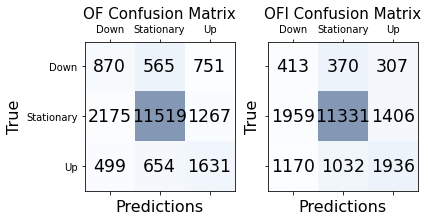

In [331]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
    
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True)

mat_con1 = confusion_matrix(model_details['OF']['test_y'].argmax(axis=1), 
                           model_details['OF']['pred_y'].argmax(axis=1))
mat_con2 = confusion_matrix(model_details['OFI']['test_y'].argmax(axis=1), 
                           model_details['OFI']['pred_y'].argmax(axis=1))

for ax in zip((ax1,ax2),(mat_con1,mat_con2),('OF','OFI')):
    ax[0].matshow(ax[1], cmap=plt.cm.Blues, alpha=0.5)
    
    for m in range(ax[1].shape[0]):
        for n in range(ax[1].shape[1]):
            ax[0].text(x=m, y=n, s=ax[1][m, n], va='center', ha='center', size='xx-large')

    ax[0].set_xlabel('Predictions', fontsize=16)
    ax[0].set_ylabel('True', fontsize=16)
    plt.xticks(np.arange(3), ['Down', 'Stationary', 'Up'])
    plt.yticks(np.arange(3), ['Down', 'Stationary', 'Up'], rotation='vertical', va='center')
    ax[0].set_title(ax[2] + ' Confusion Matrix', fontsize=15)
    
fig.tight_layout()

The confusion matrices reinforce the fact that the order flow model makes better predictions. This is particularly the case when it comes to upward moves; the order flow model is more illiberal in its propensity to make upward predictions, but the predictions it does make are clearly more in line with the true moves.

## Building a Trading Signal

Now, these evaluation metrics are cool and all, but is there a profitable trading strategy utilizing this model? How risky is it? And how can uncertainty information be used to inform trading decisions?

To answer this, we compare two trading strategies using our test set as the trading period. We ignore transaction costs, close positions at the end of the trading period, and trade the mid price of the limit order book.

In [287]:
# Store the values we trade
for time_series in model_details:
    model_details[time_series]['test_mid'] = (lob_data.iloc[1+int(len(model_details[time_series]['data'])*train_weight):]['PRICE_ASK_0'] 
                  + lob_data.iloc[1+int(len(model_details[time_series]['data'])*train_weight):]['PRICE_BID_0']) / 2


### Softmax Trading Strategy
For this strategy, we choose a threshold probability $\alpha$ and go long if $\hat{p}_{1,t}>\alpha$ and go short if $\hat{p}_{-1,t}>\alpha$, where $\hat{p}_{1,t}$ is the predicted probability of the mid price increasing at time $t$ and $\hat{p}_{-1,t}$ is the predicted probability of the mid price decreasing at time $t$. We store the cumulative profits and their ratios to transaction volume ratios for a few threshold values.

In [394]:
alphas = [0.7,0.8,0.9]

for time_series in model_details:
    for a in alphas:
        
        position = 0
        entry_last = None
        pnl = 0
        num_trades = 0
        
        for t in range(len(model_details[time_series]['preds_mean'])):

            if np.argmax(model_details[time_series]['preds_mean'][t]) == 2 and np.max(model_details[time_series]['preds_mean'][t]) > a:
                # Increase long position
                position += 1
                entry_now = model_details[time_series]['test_mid'].iloc[t]
                if entry_last != None:
                    pnl += entry_now - entry_last
                entry_last = entry_now
                num_trades += 1

            elif np.argmax(model_details[time_series]['preds_mean'][t]) == 0 and np.max(model_details[time_series]['preds_mean'][t]) > a:
                # Increase short position
                position -= 1
                entry_now = model_details[time_series]['test_mid'].iloc[t]
                if entry_last != None:
                    pnl += entry_last - entry_now
                entry_last = entry_now
                num_trades += 1
                
        # close position
        if position > 0:
            # sell to close
            entry_now = model_details[time_series]['test_mid'].iloc[-1]
            pnl += position * (entry_last - entry_now)
            num_trades += 1
        elif position < 0:
            # buy to close
            entry_now = model_details[time_series]['test_mid'].iloc[-1]
            pnl += -position * (entry_now - entry_last)
            num_trades += 1

        model_details[time_series]['softmax_profits_{}'.format(a)] = pnl
        model_details[time_series]['softmax_profits_normalized_{}'.format(a)] = pnl/num_trades


### Bayesian Trading Strategy
This strategy borrows BDLOB's use of *predictive [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory))* to summarize classification uncertainty due to variational dropout[<sub>[2]</sub>](#ref2). The metric of predictive entropy $\mathbb{H}$ follows from our aforementioned understanding of conditional expectation by making use of the predictive distribution captured in our 100 forward passes from earlier. For an input $x_t$, a predicted output $y_t$, training data $\mathcal{D}_{\text{train}}$, and estimated model parameters $\hat{w}$, we define predictive entropy by
$$
\begin{equation}
     \begin{aligned}
     \mathbb{H}(y_{t}|x_{t},\mathcal{D}_{\text{train}}) &= -\sum_{j=-1}^{1} p(y_{t}=j|x_{t},\mathcal{D}_{\text{train}})\log p(y_{t}=j|x_{t},\mathcal{D}_{\text{train}}) \\
    &\approx -\sum_{j=-1}^{1} \left( \frac{1}{100}\sum_{k=1}^{100} p(y_{t}=j|x_{t},\hat{w})\right) \log \left(\frac{1}{100}\sum_{k=1}^{100} p(y_{t}=j|x_{t},\hat{w})\right) \\
    &=: \tilde{\mathbb{H}}_t.
    \end{aligned}
\end{equation}
$$

Essentially, $j$ iterates over each class and summarizes the average level of uncertainty for outcomes of that class. The function is minimized when the model is certain; one class has probability 1 and all others are 0. The function is maximized when the model is very uncertain; probability is uniform across the classes. Also observe that our earlier notation $\hat{p}_{j,t}$ is shorthand for $\frac{1}{100}\sum_{k=1}^{100} p(y_{t}=j|x_{t},\hat{w})$.

Using this metric, we upsize our positions if our model is certain and downsize our positions if the model is uncertain. More specifically, we still go long or short if $\hat{p}_{1,t}>\alpha$ or $\hat{p}_{-1,t}>\alpha$, respectively, but we upsize our positions to $1.5 \times \mu$ if $\tilde{\mathbb{H}}_t<\beta_1$, keep our size $\mu$ if $\beta_1< \tilde{\mathbb{H}}_t < \beta_2$, and downsize to $0.5 \times \mu$ if $\tilde{\mathbb{H}}_t>\beta_2$. Like in BDLOB, we fix values for $\alpha$ and $\beta_1$ and test different values for $\beta_2$[<sub>[2]</sub>](#ref2).

In [393]:
threshold = 0.7
beta1 = 0.3
beta2 = [0.6,0.7,0.8]

for time_series in model_details:
    for b2 in beta2:
        
        long_position = 0
        short_position = 0
        entry_last = None
        pnl = 0
        num_trades = 0
        
        for t in range(len(model_details[time_series]['preds_mean'])):
            
            entropy = -np.sum(np.max(model_details[time_series]['preds_mean'][t])*
                              np.log(np.max(model_details[time_series]['preds_mean'][t])))
            
            if np.argmax(model_details[time_series]['preds_mean'][t]) == 2 and np.max(model_details[time_series]['preds_mean'][t]) > threshold:
                entry_now = model_details[time_series]['test_mid'].iloc[t]
                if beta1 < entropy < b2:
                    # enter long
                    long_position += 1
                    if entry_last != None:
                        pnl += entry_now - entry_last
                    entry_last = entry_now
                    num_trades += 1
                    
                elif entropy < beta1:
                    # enter upsized long
                    long_position += 1.5
                    if entry_last != None:
                        pnl += 1.5 * (entry_now - entry_last)
                    entry_last = entry_now
                    num_trades += 1
                
                else: # entropy > b2
                    # enter downsized long
                    long_position += 0.5
                    if entry_last != None:
                        pnl += 0.5 * (entry_now - entry_last)
                    entry_last = entry_now
                    num_trades += 1
            
            elif np.argmax(model_details[time_series]['preds_mean'][t]) == 0 and np.max(model_details[time_series]['preds_mean'][t]) > threshold:
                entry_now = model_details[time_series]['test_mid'].iloc[t]
                if beta1 < entropy < b2:
                    # enter short
                    short_position += 1
                    if entry_last != None:
                        pnl += entry_last - entry_now
                    entry_last = entry_now
                    num_trades += 1
                    
                elif entropy < beta1:
                    # enter upsized short
                    short_position += 1.5
                    if entry_last != None:
                        pnl += 1.5 * (entry_last - entry_now)
                    entry_last = entry_now
                    num_trades += 1
                    
                else: # entropy > b2
                    # enter downsized short
                    short_position += 0.5
                    if entry_last != None:
                        pnl += 0.5 * (entry_last - entry_now)
                    entry_last = entry_now
                    num_trades += 1
                              
        # close position
        if long_position - short_position > 0:
            # sell to close
            entry_now = model_details[time_series]['test_mid'].iloc[-1]
            pnl += (long_position - short_position) * (entry_last - entry_now)
            num_trades += 1
        elif long_position - short_position < 0:
            # buy to close
            entry_now = model_details[time_series]['test_mid'].iloc[-1]
            pnl += (short_position - long_position) * (entry_now - entry_last)
            num_trades += 1
        
        model_details[time_series]['bayesian_profits_({b1},{b2})'.format(b1=beta1,b2=b2)] = pnl
        model_details[time_series]['bayesian_profits_normalized_({b1},{b2})'.format(b1=beta1,b2=b2)] = pnl/num_trades
            

### Results
Now comes the question of how we should compare these strategies in terms of profit and risk. 

Since each strategy returns different transaction volumes, we use the ratio of profit to transaction volume to compare profitability. And while the [Sharpe ratio](https://en.wikipedia.org/wiki/Sharpe_ratio) is a popular measure of risk in a portfolio or strategy, it deems large positive and negative returns to be equally risky, so we follow BDLOB in using the Downward Deviation Ratio $ \text{DDR} = \frac{E(R_t)}{\text{DD}_T} $ as our risk measure, where $E(R_t)$ is the average return per timestamp and $\text{DD}_T=\sqrt{\frac{1}{T} \sum_{t=1}^T \text{min}(R_t,0)^2}$[<sub>[2]</sub>](#ref2). DDR, which is essentially the [Sortino ratio](https://en.wikipedia.org/wiki/Sortino_ratio) with a target rate of 0, has the desired property of penalizing negative returns and rewarding positive returns.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['softmax_{}'.format(a) for a in alphas] + ['bayesian_{,}'.format(beta1,b2) for b2 in beta2]
fig, (ax1, ax2) = plt.subplots(1, 2)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Normalized Profit Plots
of_profits_normalized = [model_details['OF']['softmax_profits_normalized_{}'.format(a)] for a in alphas] +
            [model_details['OF']['bayesian_profits_normalized_({,})'.format(beta1,b2)] for b2 in beta2]

ofi_profits_normalized = [model_details['OFI']['softmax_profits_normalized_{}'.format(a)] for a in alphas] +
            [model_details['OFI']['bayesian_profits_normalized_({,})'.format(beta1,b2)] for b2 in beta2]

rects1 = ax1.bar(x - width/2, of_profits_normalized, width, label='OF')
rects2 = ax1.bar(x + width/2, ofi_profits_normalized, width, label='OFI')
 
ax1.set_ylabel('Normalized Profit')
ax1.set_title('Normalized Profit by Strategy and Model')
ax1.set_xticks(x, labels)
ax1.legend()

ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)


# DDR Plots
of_ddr = [model_details['OF']['softmax_profits_normalized_{}'.format(a)] for a in alphas] +
            [model_details['OF']['bayesian_profits_normalized_({,})'.format(beta1,b2)] for b2 in beta2]

ofi_ddr = [model_details['OFI']['softmax_profits_normalized_{}'.format(a)] for a in alphas] +
            [model_details['OFI']['bayesian_profits_normalized_({,})'.format(beta1,b2)] for b2 in beta2]

rects1 = ax2.bar(x - width/2, of_ddr, width, label='OF')
rects2 = ax2.bar(x + width/2, ofi_ddr, width, label='OFI')

ax2.set_ylabel('DDR')
ax2.set_title('DDR by Strategy and Model')
ax2.set_xticks(x, labels)
ax2.legend()

ax2.bar_label(rects1, padding=3)
ax2.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

<AxesSubplot:>

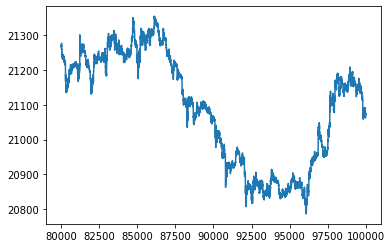

In [414]:
model_details['OF']['test_mid'].plot()

# Model Diagnostics
To be in acccordance with the Box-Jenkins approach, we test the fitted models' residuals $\left\{\hat{u}_i\right\}_{i=1}^{T}$ for any [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)—that is, we check whether residuals are correlated to past residuals in the sequence. If true, there is statistical evidence that the model is underfitting, and we should increase the lag parameter of our sequential model and re-train. If false, we accept the model residuals to be [white noise](https://en.wikipedia.org/wiki/White_noise). 

We compute our residuals as the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) of the classification problem at each timestamp, which we define by
$$ \hat{u}_i=-\sum_{j=-1}^{1}y_i(j)\log\hat{y}_i(j) $$
for $i\in\left\{1,...,T\right\}$, where $y_i$ is the [one-hot encoded](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) 3-variable vector of the true 1-step movement, $\hat{y}_i$ is our model's unrounded prediction of that encoding, and $T$ is the number of observations.

Letting $\hat{\tau}_i$ be the sample autocorrelations of the residuals and $m$ to be a maximum lag to test, we use the Ljung-Box statistic
$$ Q(m) = T(T+2)\sum_{l=1}^{m}\frac{\hat{\tau}_l^2}{T-l} $$
as our test statistic for the null hypothesis $H_0: \tau_1=...=\tau_m=0$ versus the alternative $H_a: \tau_i\neq0$ for some $i\in\left\{1,...,m\right\}$. For large $T$, the statistic is chi-squared distributed with $m$ degrees of freedom, and we reject the null in favor of the alternative if the test statistic is greater than the critical value of the corresponding chi-squared distribution at the 99% confidence level. 

In [407]:
from statsmodels.stats.diagnostic import acorr_ljungbox

with device('cpu:0'):
    for time_series in model_details:
        residuals = -np.sum(model_details[time_series]['train_y']*
                           np.log(model_details[time_series]['model'].predict(model_details[time_series]['train_x'])),
                           axis=1)
        lb, p = acorr_ljungbox(residuals, lags=100, boxpierce=False, return_df=False)
        if len(p[p < 0.01]) > 0:
            print(time_series + " is underfitting.")
        else:
            print(time_series + " is not underfitting.")


OF is underfitting.
OFI is underfitting.


Unfortunately, we conclude that both models are underfitting the training data, so we should increase the lag parameter and redo the training and diagnostics until we no longer underfit. However, we don't pursue this route for a pair of reasons. For one, while there is no risk of overfitting the deep learning model as we increase the lag, doing so would increase computational time. With the current lag, iterating through the cross-validation and training takes many many hours already, and I'm antsy to finish this project. Secondly, the fact that the model is underfitting should come as no surprise, since this really tells us that our model is too simple for the data. Financial data, even such stationary processes as order flow and order flow imbalance, are incredibly complex, so it's hard to expect any interpretable model to well-fit the input data. In this truth lies one of the problems of deep learning in finance.

## Shortfalls of Deep Learning


Deep neural networks as a "black box"

"Offline" version of learning

## Conclusion

## References

1. <span id="ref1">Zhang, Zihao, Stefan Zohren, and Stephen Roberts (2019). “DeepLOB: Deep Convolutional Neural Networks for Limit Order Books”. In: *IEEE Transactions On Signal Processing* 67.11, pp. 3001–3012.<br>
2. <span id="ref2">Zhang, Zihao, Stefan Zohren, and Stephen Roberts (2018). “BDLOB: Bayesian Deep Convolutional Neural Networks For Limit Order Books”. In: *arXiv preprint arXiv:1811.10041*.<br>
3. <span id="ref3">Cont, Rama, Arseniy Kukanov, and Sasha Stoikov (2014). “The Price Impact Of
Order Book Events”. In: *Journal Of Financial Econometrics* 12.1, pp. 47–88.<br>
4. <span id="ref4">Kolm, Petter, Jeremy Turiel, and Nicholas Westray (2021). "Deep Order Flow Imbalance: Extracting Alpha At Multiple Horizons From The Limit Order Book". In: *Available at SSRN 3900141*.<br>
5. <span id="ref5">Lütkepohl, Helmut (2005). *New Introduction to Multiple Time Series Analysis*. Springer.<br> 
6. <span id="ref6">Dixon, Matthew F., Igor Halperin, and Paul Bilokon (2020). *Machine Learning in Finance: From Theory to Practice*. Springer.<br>
7. <span id="ref7">Hochreiter, Sepp and Jürgen Schmidhuber (1997). “Long Short-Term Memory”. In: *Neural Computation* 9.8, pp. 1735–1780.<br>
8. <span id="ref8">Ntakaris, Adamantios, Martin Magris, Juho Kanniainen, Moncef Gabbouj, and Alexandros Iosifidis (2018). “Benchmark Dataset For Mid-Price Forecasting Of Limit Order Book Data With Machine Learning Methods”. In: *Journal of Forecasting* 37.8, pp. 852–866.<br>
9. <span id="ref9">Yang, Kiyoung, and Cyrus Shahabi (2005). "On the Stationarity of Multivariate Time Series for Correlation-Based Data Analysis". In: *Fifth IEEE International Conference on Data Mining*, pp. 1-4.<br>
10. <span id="ref10">Gal, Yarin (2016). *Uncertainty in Deep Learning*. Phd Thesis, University of Cambridge.<br>

- Szegedy, Christian, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, and Andrew Rabinovich (2015). “Going Deeper With Convolutions”. In: *Proceedings Of The IEEE Conference On Computer Vision And Pattern Recognition*, pp. 1–9.<br>

- Tsay, Ruey S. (2010). *Analysis of Financial Time Series* (3rd ed.). Wiley.<br>
- Johansen, Søren (1995). *Likelihood-Based Inference in Cointegrated Vector Autoregressive Models*. Oxford University Press.<br>